# 1 IMPORTS AND FUNCTIONS

In [1]:
import math
import random
import pickle
import warnings
import inflection
import datetime
import numpy                                   as np
import pandas                                  as pd
import seaborn                                 as sns
import xgboost                                 as xgb
from scipy                 import stats        as ss
from matplotlib            import pyplot       as plt
from matplotlib.gridspec   import GridSpec
from scipy.stats           import chi2_contingency
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 1.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    # Matplotlib settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    # Display settings
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None 
    pd.set_option( 'display.expand_frame_repr', False ) 

    # Seaborn settings
    sns.set()
jupyter_settings()


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse }, index=[0] )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Define start and end date for the validation set
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k - 1) * 6 * 7)
        
        # Split the data into training and validation sets
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        m = model.fit(xtraining, ytraining)
        
        yhat = m.predict(xvalidation)
        
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    
    # Return a DataFrame with the aggregated performance metrics
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])
    
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.

    Parameters:
    x : array-like
        The first categorical variable.
    y : array-like
        The second categorical variable.

    Returns:
    float
        Cramér's V statistic.
    """
    # Create the contingency table
    cm = pd.crosstab(x, y).values

    # Total number of observations
    n = cm.sum()

    # Number of rows and columns in the contingency table
    r, k = cm.shape

    # Calculate chi-squared statistic
    chi2 = chi2_contingency(cm)[0]

    # Apply correction
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    # Calculate Cramér's V
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))    

## 1.2 Loading Datase

In [3]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False ) 
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False ) 
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )
df1 = df_raw.copy()

# 2 Exploratory Data Analysis and Cleaning

## Assess Data Quality

# 2.1 Rename Columns

In [4]:
# List of original column names
cols_old = ['Store', 'DayOfyear', 'Date', 'Sales', 'Customers', 'Open',
            'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
df1.columns = cols_new

## 2.2 Data Dimensions

In [5]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 2.3 Data Types

In [6]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes


store                                    int64
day_ofyear                               int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check N/A

In [7]:
df1.isna().sum()

store                                0
day_ofyear                           0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 Fillout Missing Values

In [8]:
# df1.sample(5)

In [9]:
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x:200000.0 if math.isnan( x ) else x )

df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval']=df1['promo_interval'].fillna(0)
df1['month_map']=df1['date'].dt.month.map(month_map)
df1['is_promo']=df1.apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 2.5.1 Verify Missing Values

In [10]:
df1.isna().sum()

store                           0
day_ofyear                      0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.6 Convert Data Types

In [11]:
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int)

df1['promo2_since_year']=df1['promo2_since_year'].astype(int)
df1.dtypes

store                                    int64
day_ofyear                               int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.7 Define Numerical and Categorical Attributes

In [12]:
num_attributes=df1.select_dtypes(include=['int64', 'float64'])
cat_attributes=df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1 Evaluate Numerical Attributes

In [13]:
#Central Tendency (ct) and Dispersion (d)
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(np.min)).T
d3=pd.DataFrame(num_attributes.apply(np.max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m= pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
# m

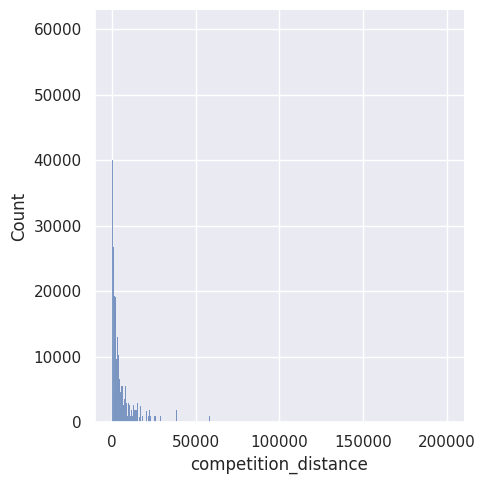

In [14]:
sns.displot(df1['competition_distance'], kde=False)

##  2.7.2 Categorical Attributes

<Axes: xlabel='assortment', ylabel='sales'>

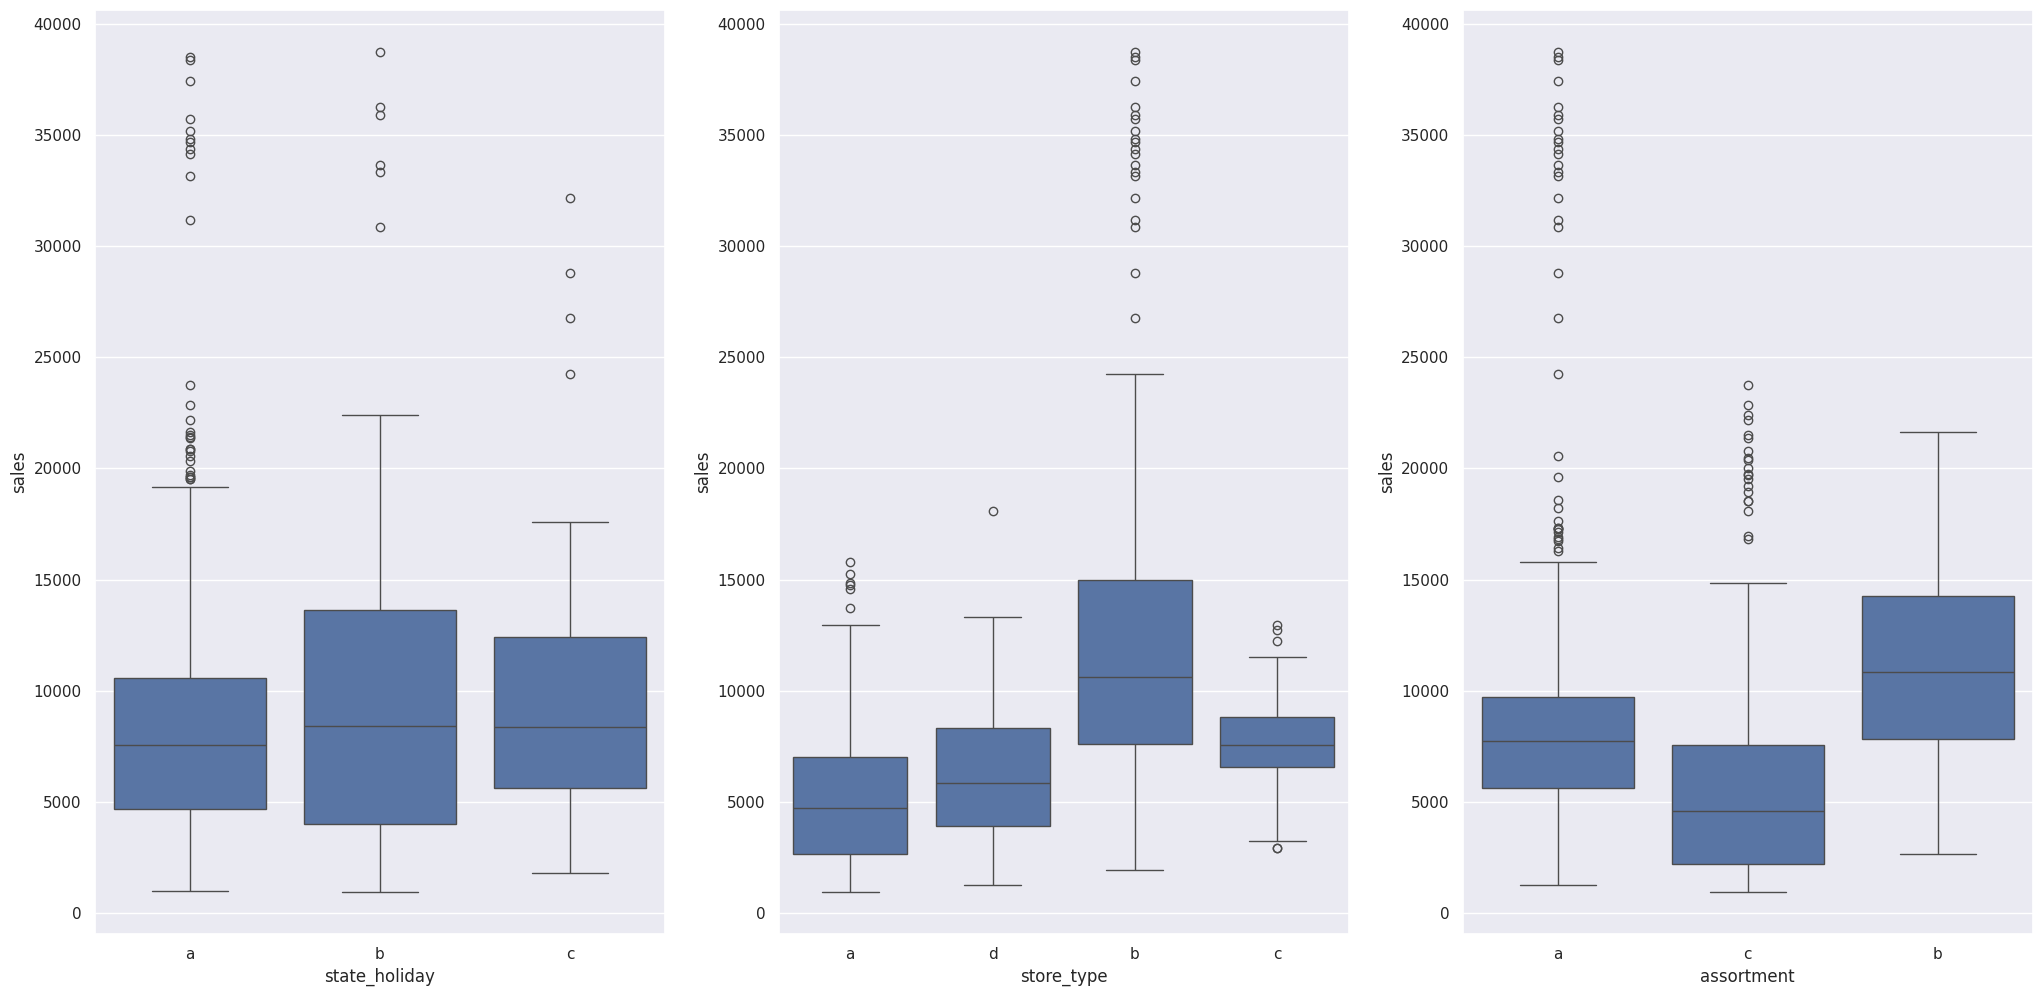

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# Boxplots for sales against categorical attributes
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 3.0 Feature Engineering

## Creation of Hypotheses

## Store Hypotheses
1. Stores with a larger number of employees should sell more.
2. Stores with greater stock capacity should sell more.
3. Larger stores should sell more.
4. Stores with a greater assortment should sell more.
5. Stores with closer competitors should sell less.
6. Stores with competitors for a longer time should sell more.

## Product Hypotheses
1. Stores that invest more in marketing should sell more.
2. Stores with greater product exposure should sell more.
3. Stores with lower-priced products should sell more.
4. Stores with more aggressive promotions (bigger discounts) should sell more.
5. Stores with promotions active for a longer time should sell more.
6. Stores with more promotion days should sell more.
7. Stores with more consecutive promotions should sell more.

## Time Hypotheses
1. Stores open during the Christmas holiday should sell more.
2. Stores should sell more over the years.
3. Stores should sell more in the second half of the year.
4. Stores should sell more after the 10th of each month.
5. Stores should sell less on weekends.
6. Stores should sell less during school holidays.

#  Final List of Hypotheses
1. Stores with a greater assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with competitors for a longer time should sell more.
4. Stores with promotions active for a longer time should sell more.
5. Stores with more promotion days should sell more.
6. Stores with more consecutive promotions should sell more.
7. Stores open during the Christmas holiday should sell more.
8. Stores should sell more over the years.
9. Stores should sell more in the second half of the year.
10. Stores should sell more after the 10th of each month.
11. Stores should sell less on weekends.
12. Stores should sell less during school holidays.

## 3.1 Feature Creation

In [16]:
df2=df1.copy()


df2['year']=df2['date'].dt.year
df2['month']=df2['date'].dt.month
df2['day']=df2['date'].dt.day
df2['week_of_year']=df2['date'].dt.isocalendar().week
df2['year_week']=df2['date'].dt.strftime('%Y-%U')

df2['competition_since']=df2.apply(
                                    lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                month=x['competition_open_since_month'],
                                                                day=1), axis=1)

# df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(
#                                                                                 lambda x: x.days).astype(int)

# Start date of a promotion based on the year and week number 
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']=df2['promo_since'].apply(
                                            lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w')-datetime.timedelta(days=7))

# Number of weeks that have passed since a promotion started 
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(
                                                                                lambda x: x.days).astype(int)

df2['assortment']=df2['assortment'].apply(
                                            lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')

df2['state_holiday']=df2['state_holiday'].apply(
                                                lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')

# 4 Variables filtering

In [17]:
df3=df2.copy()

# Filtering lines
df3=df3[(df3['open'] !=0)&(df3['sales']>0)]

# Filtering columns
cols_drop=['customers', 'open', 'promo_interval', 'month_map']
df3=df3.drop(cols_drop,axis=1)

# 5 Data Distribution Analysis

In [18]:
df4=df3.copy()

## 5.1 Univariate analysis
### 5.1.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

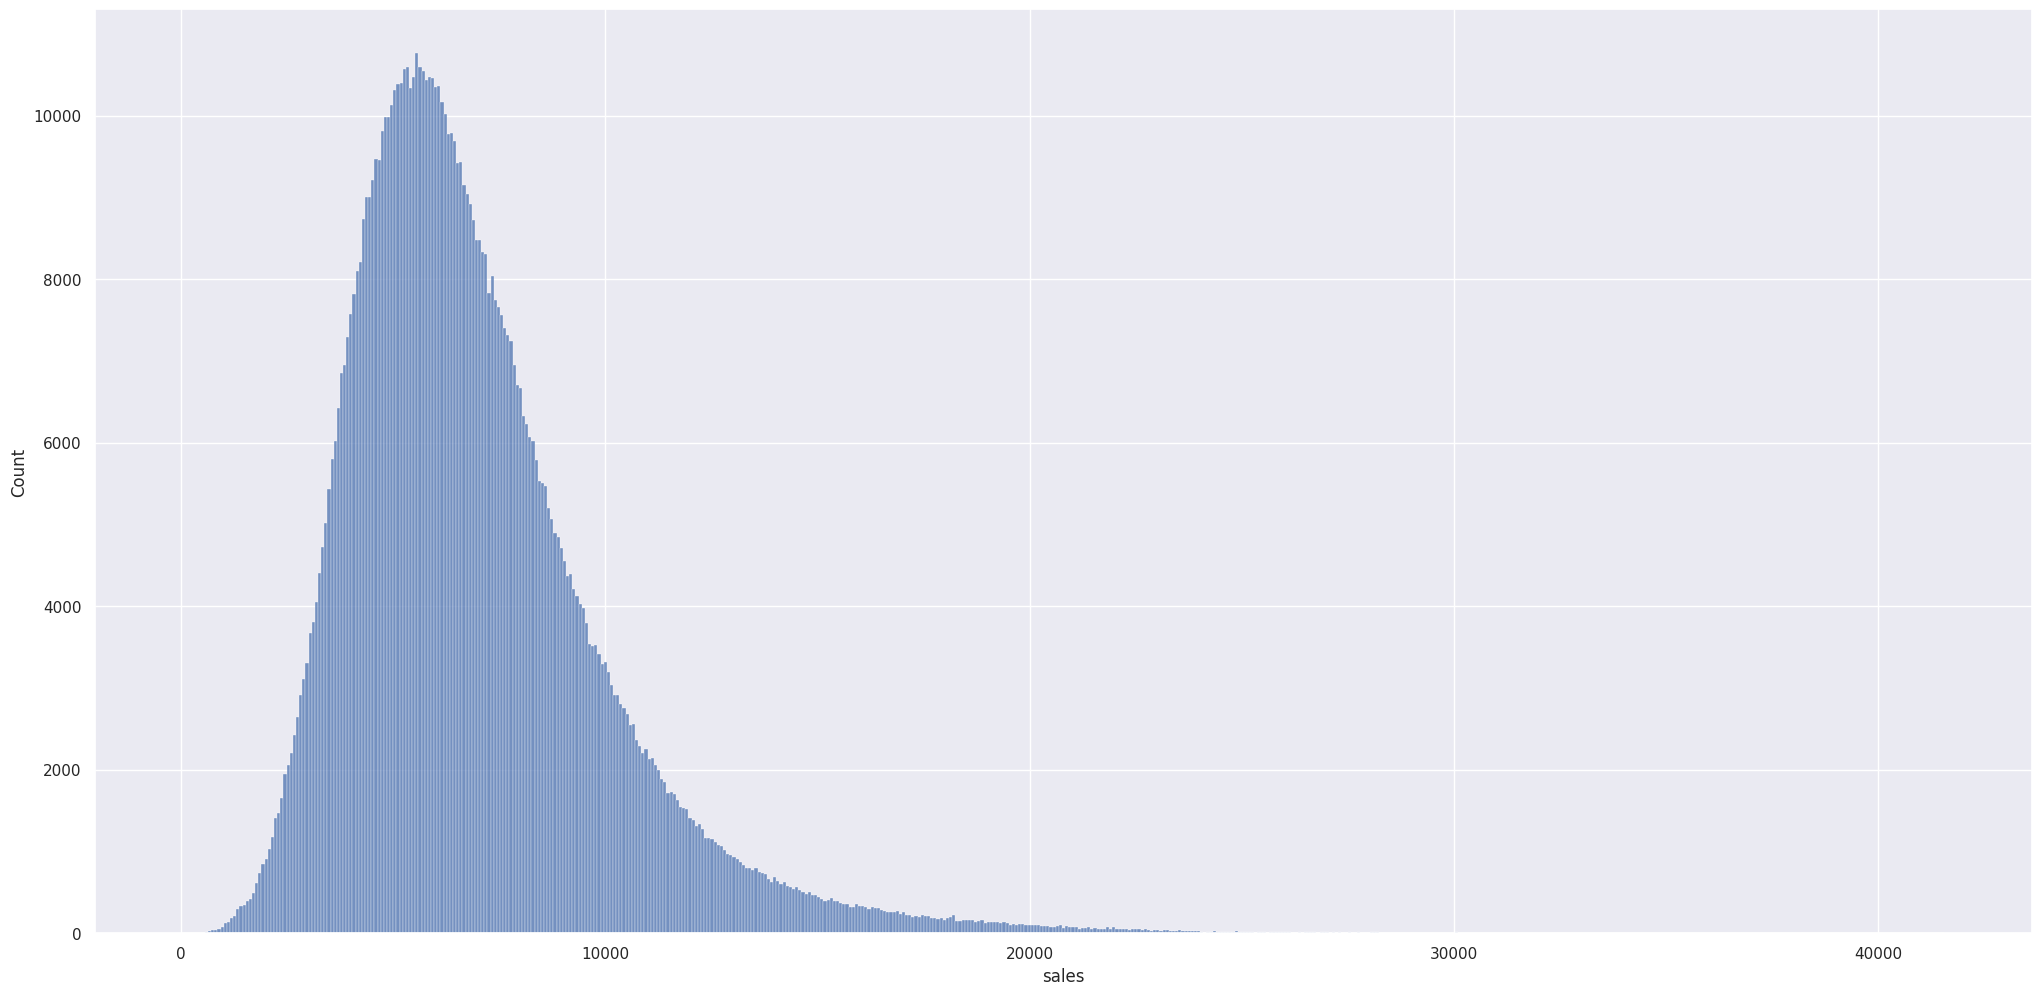

In [19]:
sns.histplot(df4['sales'], kde=False)

### 5.1.2 Numerical Variables

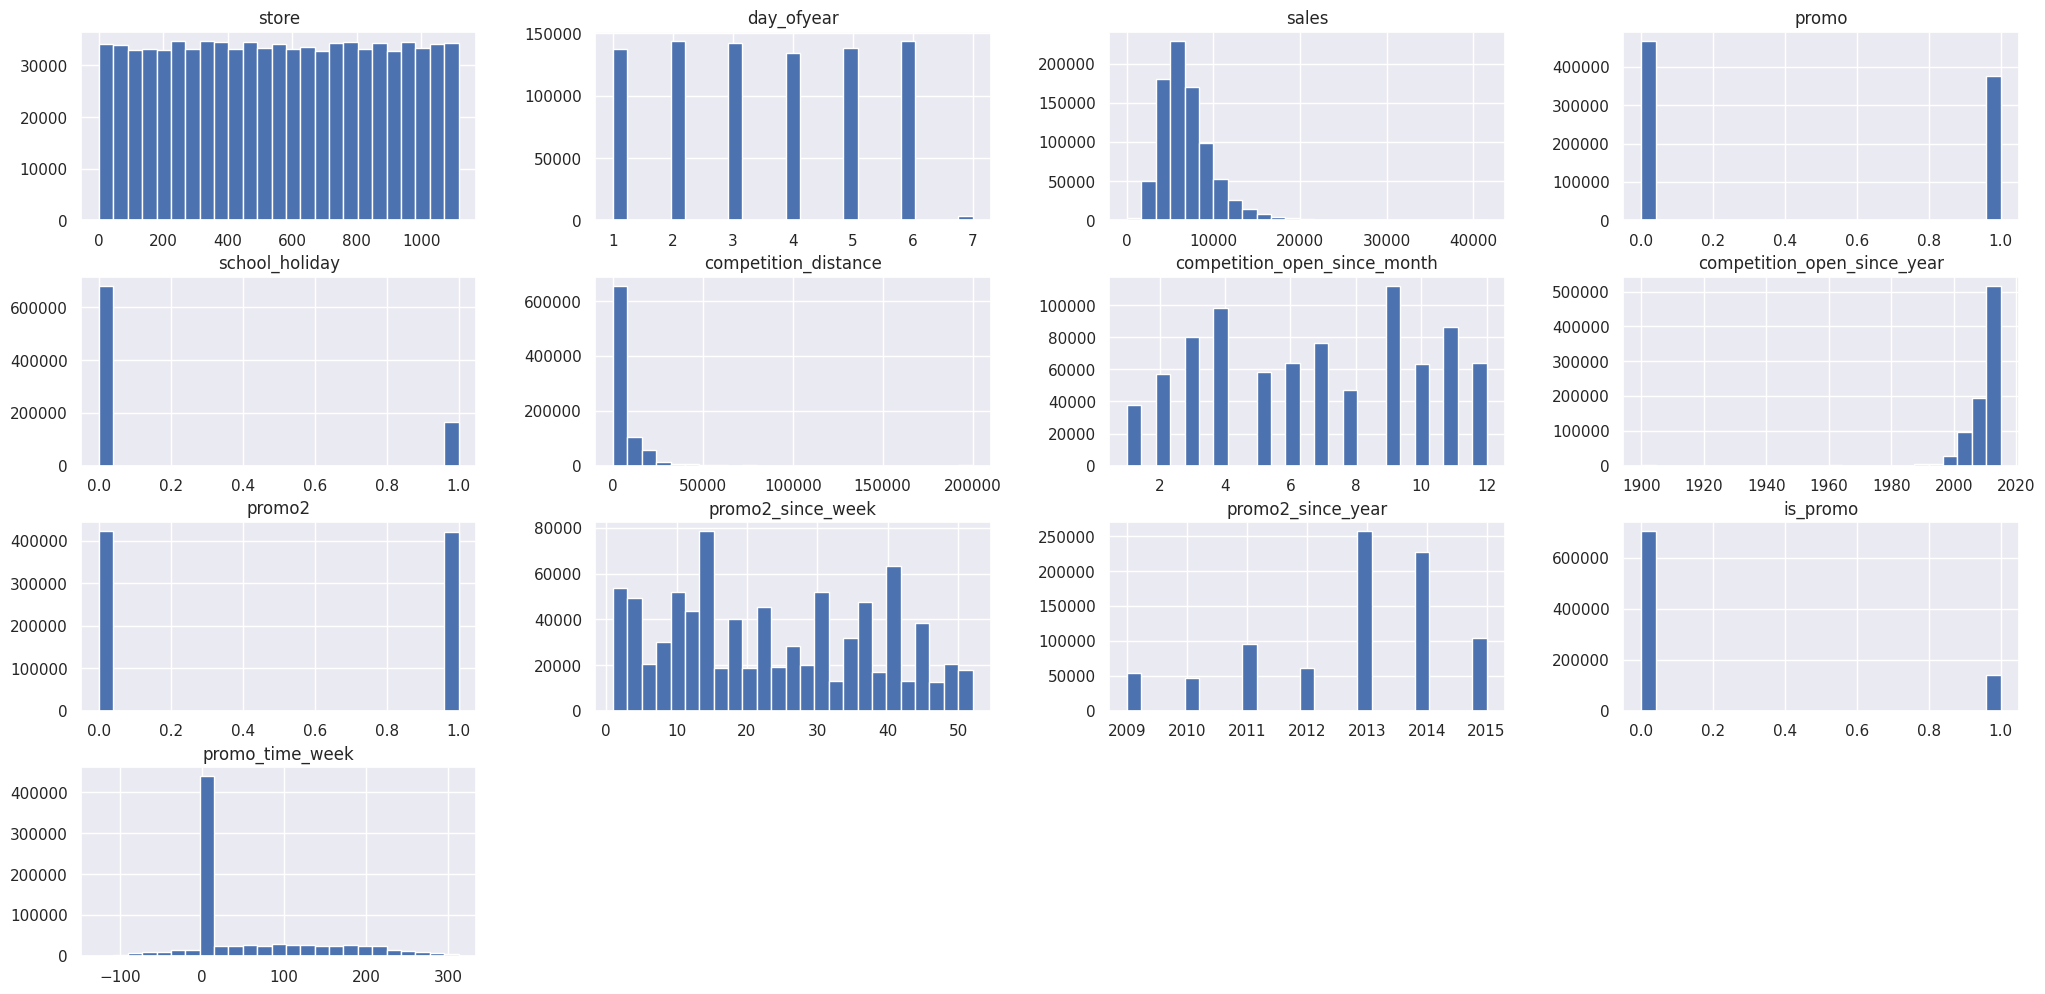

In [20]:
#define numerical and categorical attributes
num_attributes=df4.select_dtypes(include=['int64', 'float64'])
cat_attributes=df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
num_attributes.hist(bins=25);

### 5.1.3 Categorical Variable

<Axes: xlabel='sales', ylabel='Density'>

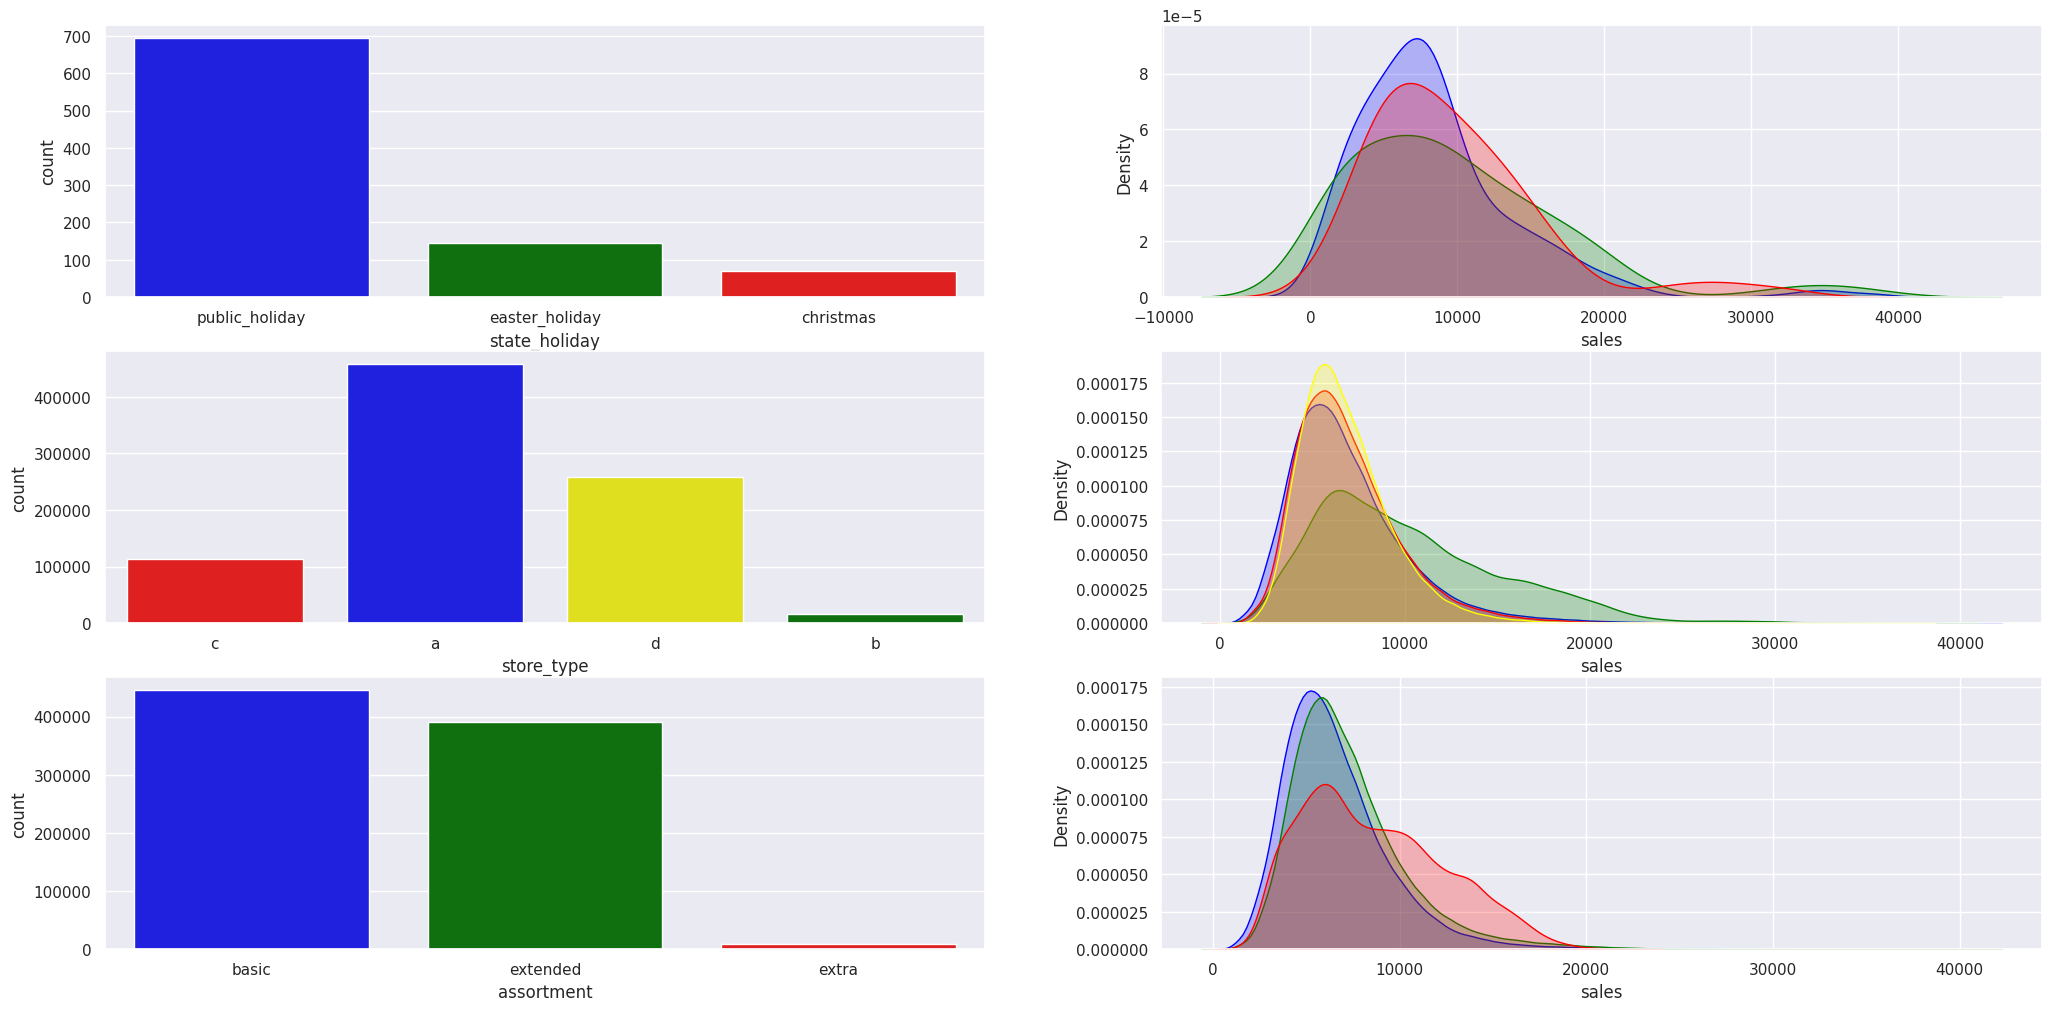

In [21]:
# State Holiday Analysis
# Count the number of occurrences for each state holiday type, excluding 'regular_day'.
# Visualize the distribution of sales for each state holiday using KDE plots.
palette={'public_holiday':'blue', 'easter_holiday':'green', 'christmas':'red'}
plt.subplot(3,2,1)
a=df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday', palette=palette, hue='state_holiday')
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday',fill=True, color=palette['public_holiday'])
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',fill=True, color=palette['easter_holiday'])
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',fill=True, color=palette['christmas'])


# Store Type Analysis
# Count the number of stores by type and visualize sales distributions for each store type.
palette={'a':'blue', 'b':'green', 'c':'red', 'd':'yellow'}
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', palette=palette, hue='store_type')
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',fill=True, color=palette['a'])
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',fill=True, color=palette['b'])
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',fill=True, color=palette['c'])
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',fill=True, color=palette['d'])


# Assortment Analysis
# Count the occurrences of each assortment type and visualize the sales distribution for each.
palette={'basic':'blue', 'extended':'green', 'extra':'red'}
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', palette=palette, hue='assortment')
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',fill=True, color=palette['basic'])
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended',fill=True, color=palette['extended'])
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',fill=True, color=palette['extra'])

# Findings from the analysis:
# 'Easter_holiday' and 'christmas' both show higher sales peaks, indicating these holidays drive more significant sales events.
# Store type 'b' not only has fewer stores but also shows consistently lower sales, suggesting that it underperforms compared to other types.
# This suggests that increasing the variety of products (as with 'extra') does not necessarily lead to higher sales, and may indicate inefficiencies or mismatched customer preferences.

## 5.2 Bivariate Analysis

## 5.2.1 H1 - Stores with a greater assortment should sell more. = FALSE

<Axes: xlabel='year_week'>

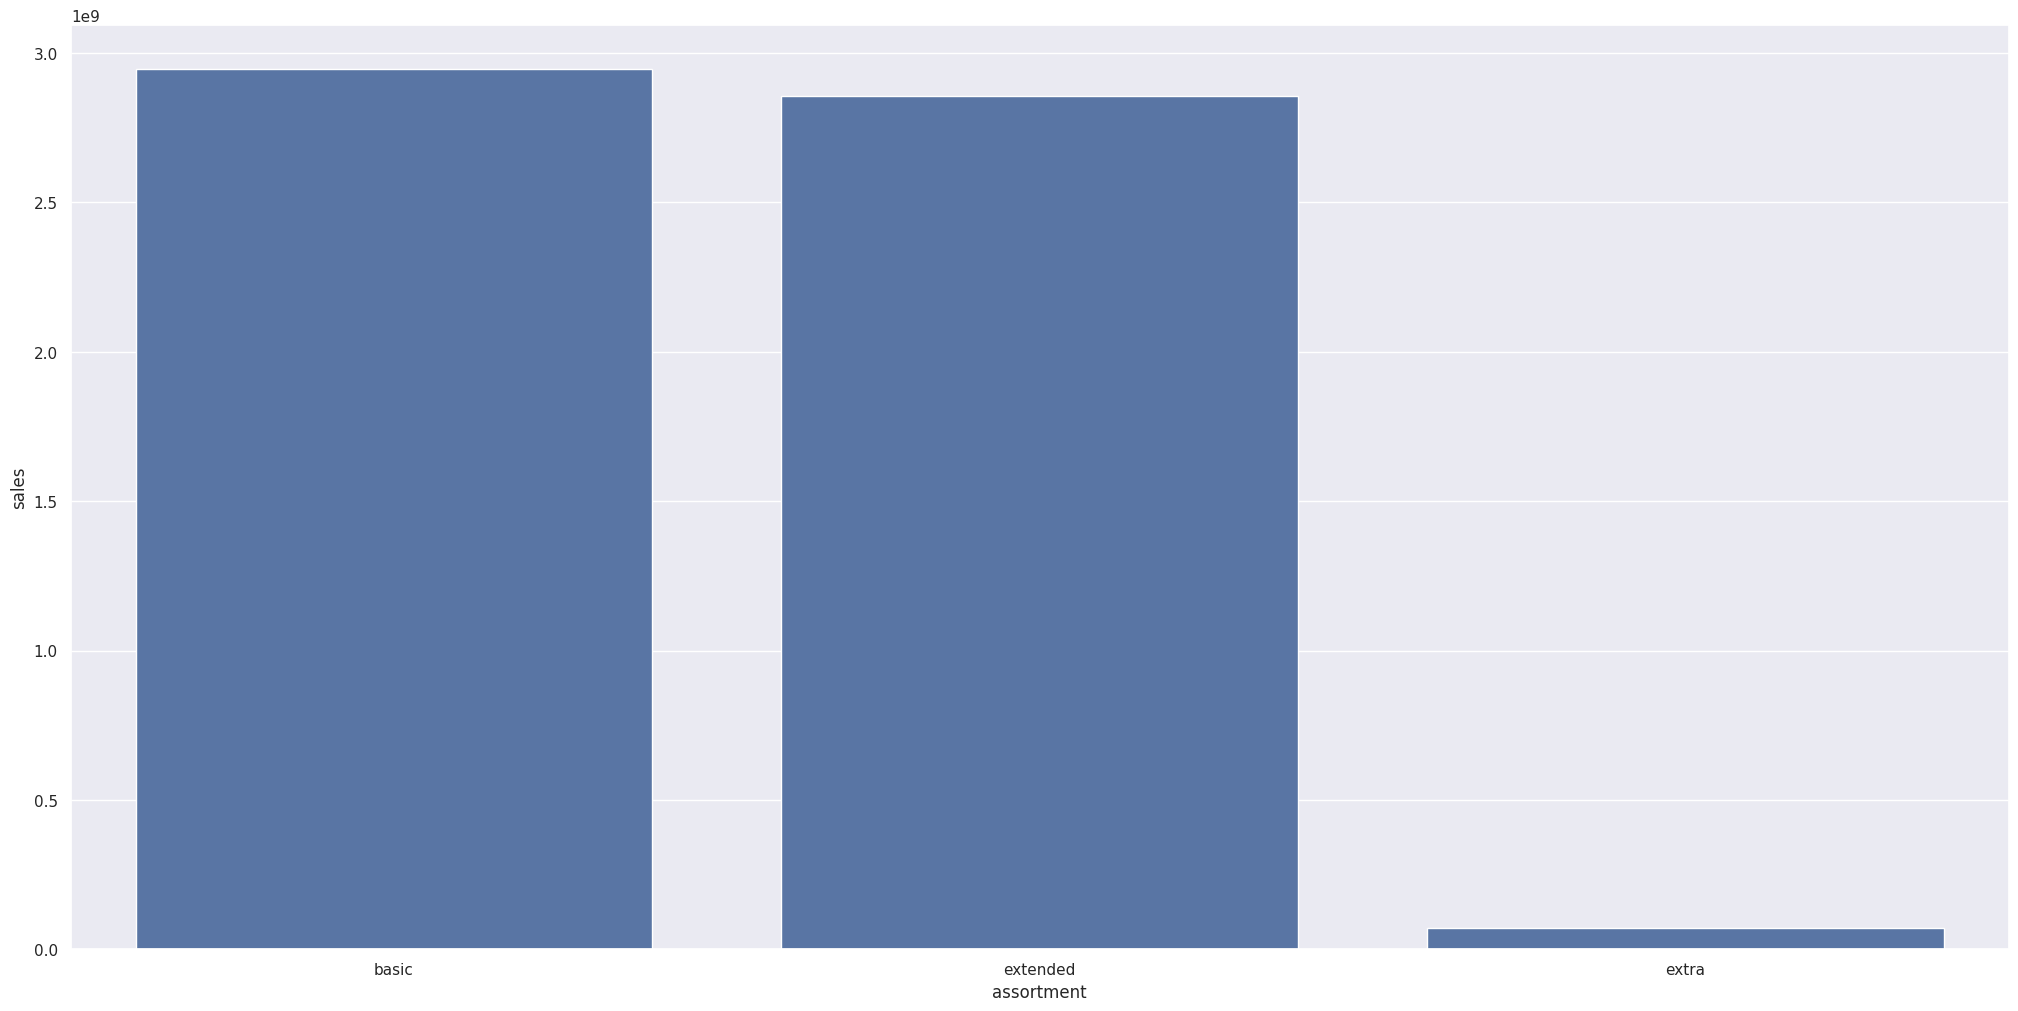

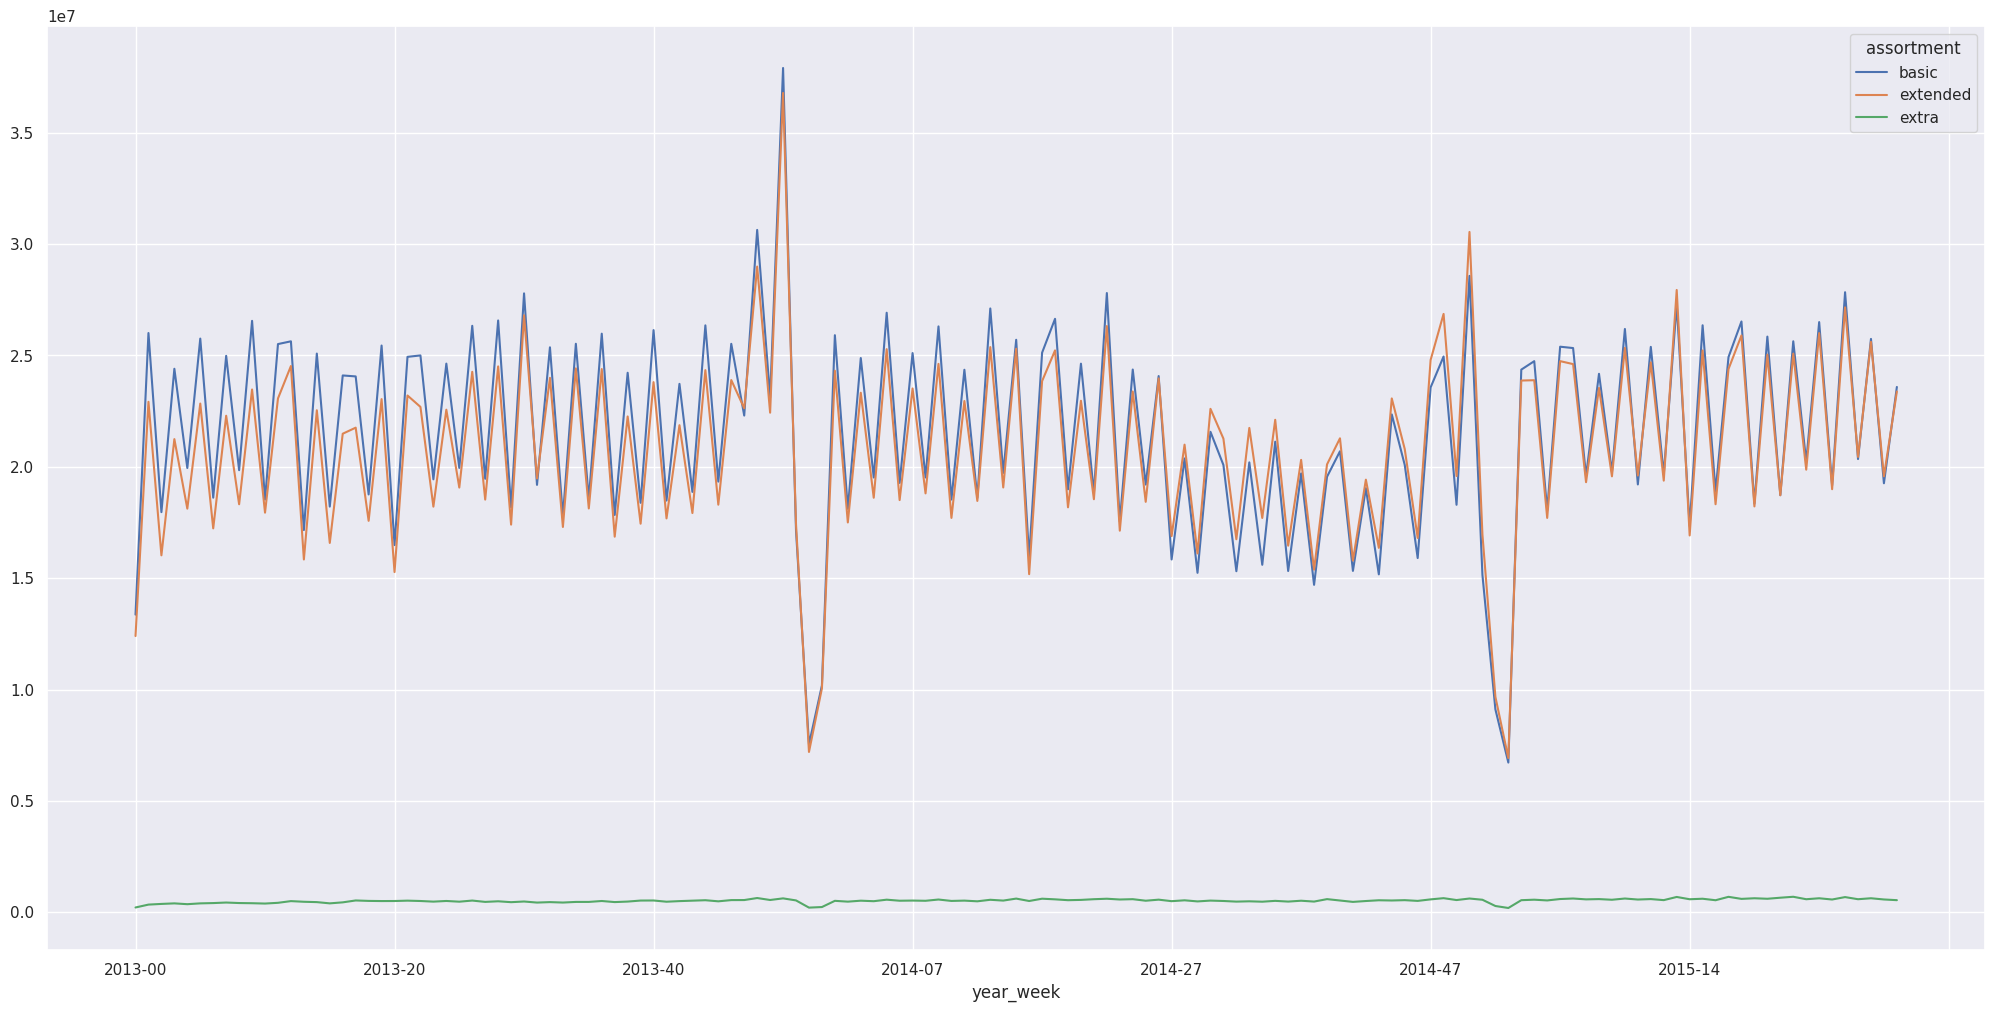

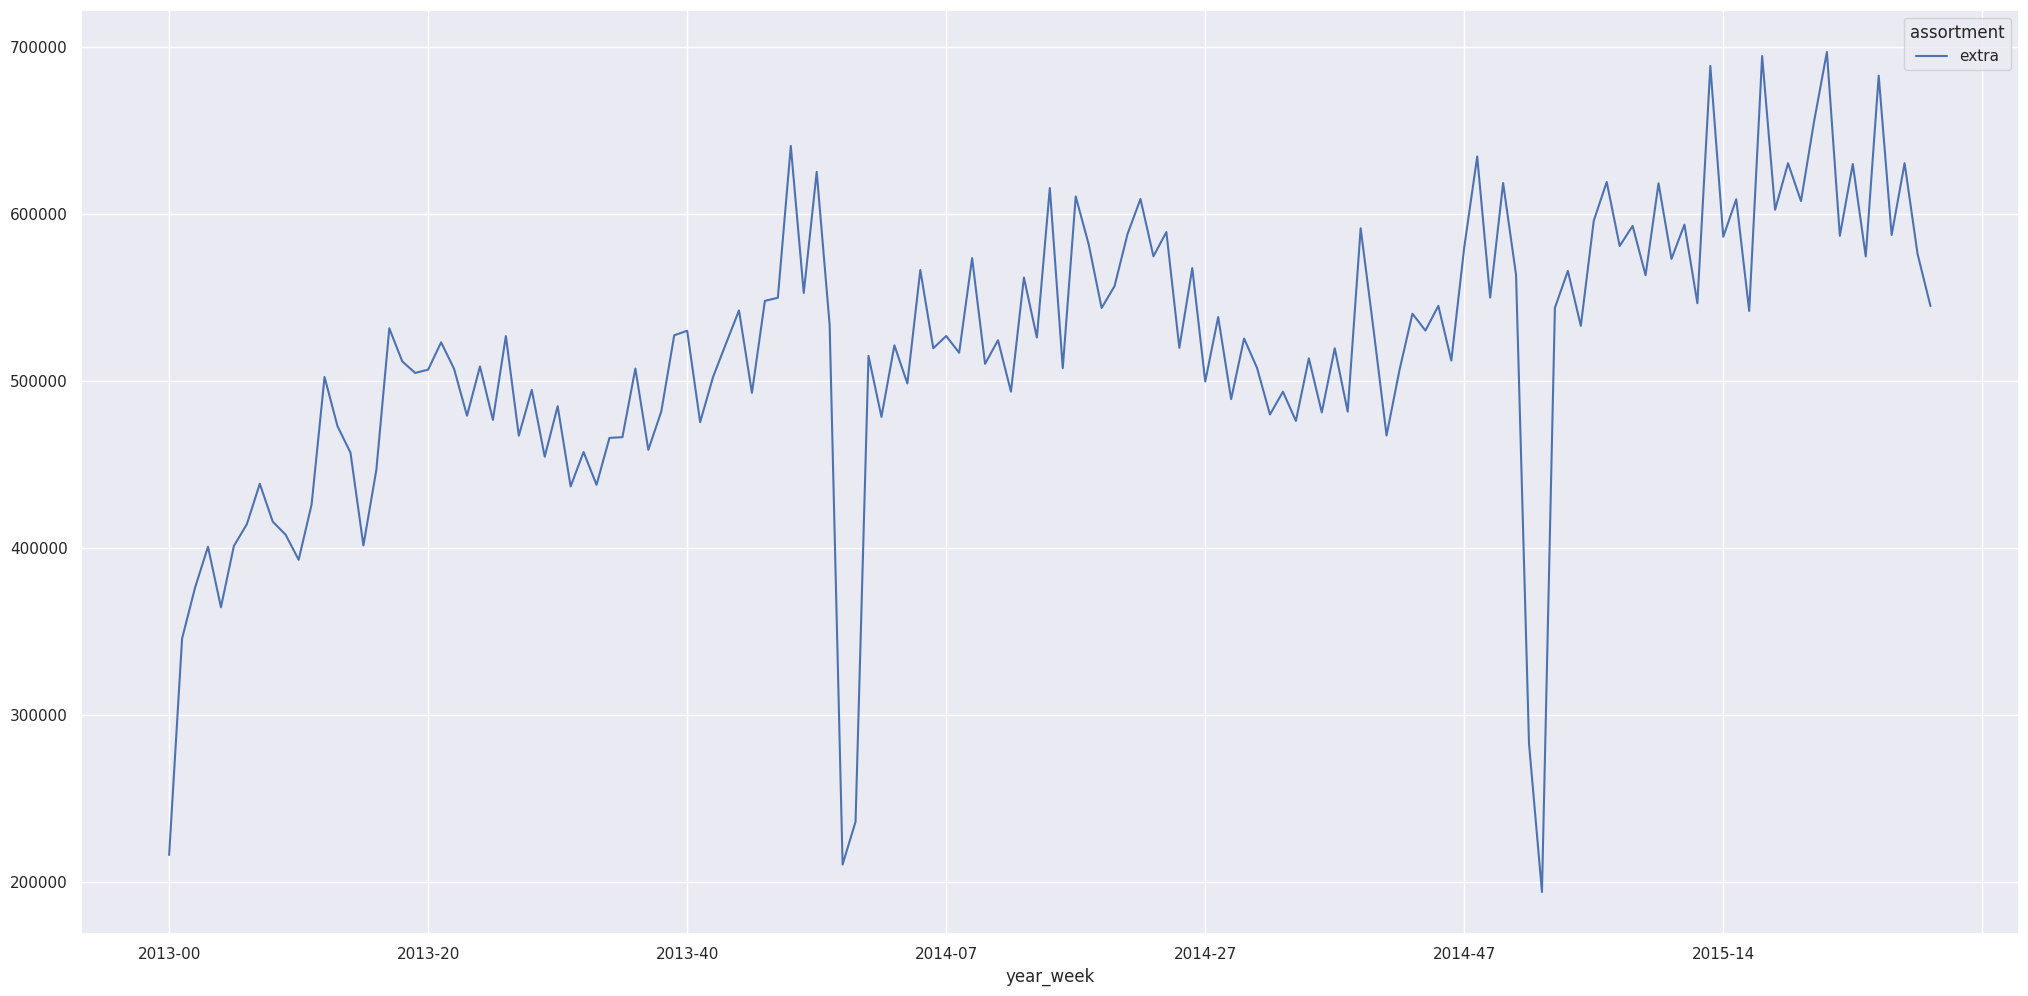

In [22]:
# Analyze total sales across assortment types
aux1= df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Explore weekly sales trends by assortment type
aux2=df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values= 'sales').plot()

# Focus on 'extra' assortment to assess its sales performance over time
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot()

# Sales: Basic and Extended assortments outperform Extra in total sales.
# Trends: Basic and Extended show stable, similar sales trends.
# Impact: Extra's underperformance suggests assortment alone doesn't drive sales; marketing and pricing matter.
# Conclusion: False.

### 5.2.2  H2 Stores with closer competitors should sell less. FALSE

Text(0.5, 1.0, 'Correlation Heatmap')

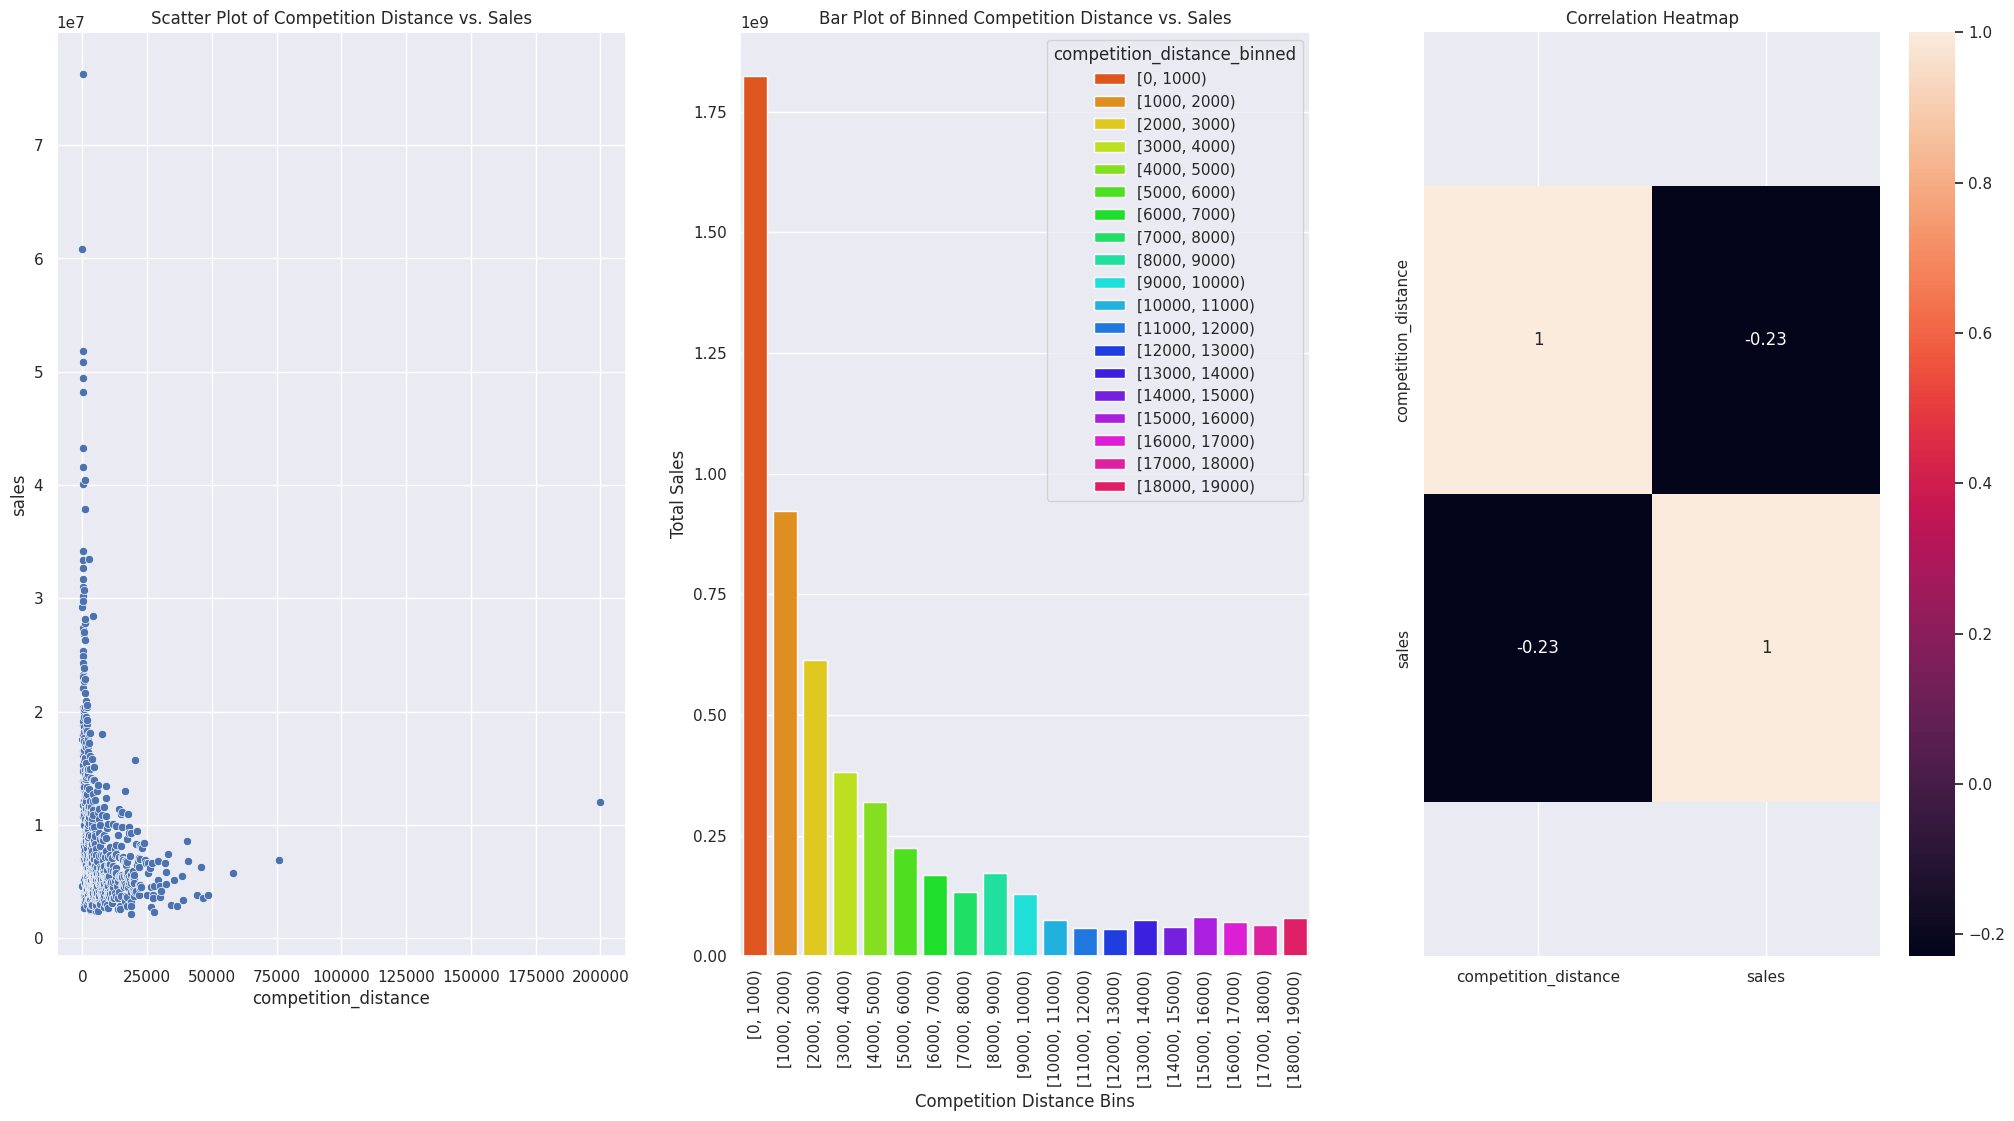

In [23]:
# Summarize sales by competition distance
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Scatter plot: Examine the relationship between competition distance and total sales
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Scatter Plot of Competition Distance vs. Sales')

# Bin competition distances and group sales by these bins
bins = list(np.arange(0, 20000, 1000))
colors = sns.color_palette('hsv', len(bins) - 1)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins, right=False, include_lowest=True)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).sum().reset_index()

# Bar plot: Visualize total sales across different competition distance bins
plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette=colors, hue='competition_distance_binned', dodge=False)
plt.xticks(rotation=90)
plt.title('Bar Plot of Binned Competition Distance vs. Sales')
plt.xlabel('Competition Distance Bins')
plt.ylabel('Total Sales')

# Correlation heatmap: Show the relationship between competition distance and sales
plt.subplot(1, 3, 3)
corr_matrix = aux1.drop(columns=['competition_distance_binned']).corr(method='pearson')
x = sns.heatmap(corr_matrix, annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation Heatmap')

# Interpretation of Competition Distance vs. Sales:
# The analysis shows that stores closer to competitors tend to have higher sales, as seen in the scatter plot and bar plot.
# The correlation heatmap also indicates a weak negative correlation between competition distance and sales, suggesting that sales decrease as the distance to competitors increases.
# Overall, the hypothesis that stores with closer competitors should sell less is proven false; proximity to competitors is associated with higher sales.
# Conclusion: False.

### 5.2.3 H3 Stores with competitors for a longer time should sell more. FALSE

KeyError: "['competition_time_month'] not in index"

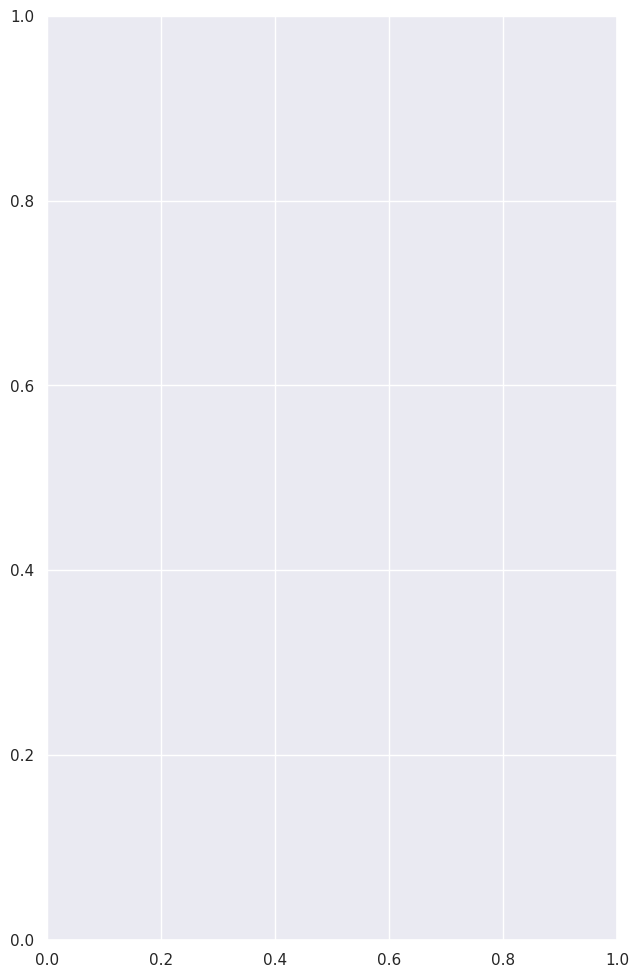

In [24]:
# Subplot 1: Bar Plot
# Visualize the distribution of sales across different competition time periods.
plt.subplot(1,3,1)
bins = list(np.arange(0, 120, 10))

# Group sales by competition time month to analyze sales trends over time.
aux1= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Filter out outliers (competition time months of 0 and >= 120) to improve visualization and analysis accuracy.
aux2=aux1[ (aux1['competition_time_month']<120)&(aux1['competition_time_month']!=0)]
colors = sns.color_palette('hsv', len(aux2['competition_time_month'].unique()))
sns.barplot(x='competition_time_month', y='sales', data=aux2, palette=colors, hue='competition_time_month',legend=False);
plt.xticks(rotation=90);

# Subplot 2: Regression Plot
# Explore the relationship between competition time month and sales.
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

# Subplot 3: Correlation Heatmap
# Analyze the correlation between different variables in the dataset.
plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top=x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

# Interpretation of Competition Time (Months) vs. Sales:
# Interpretation of Competition Time vs. Sales:
# Sales spike initially when competition begins, as shown in the bar plot.
# The regression plot indicates a weak negative trend over time, which is confirmed by the slight negative correlation in the heatmap.
# Overall, competition has an early impact on sales, but this effect weakens over time.
# Conclusion: False.


### 5.2.4 H4 Stores with promotions active for a longer time should sell more. FALSE

<Axes: >

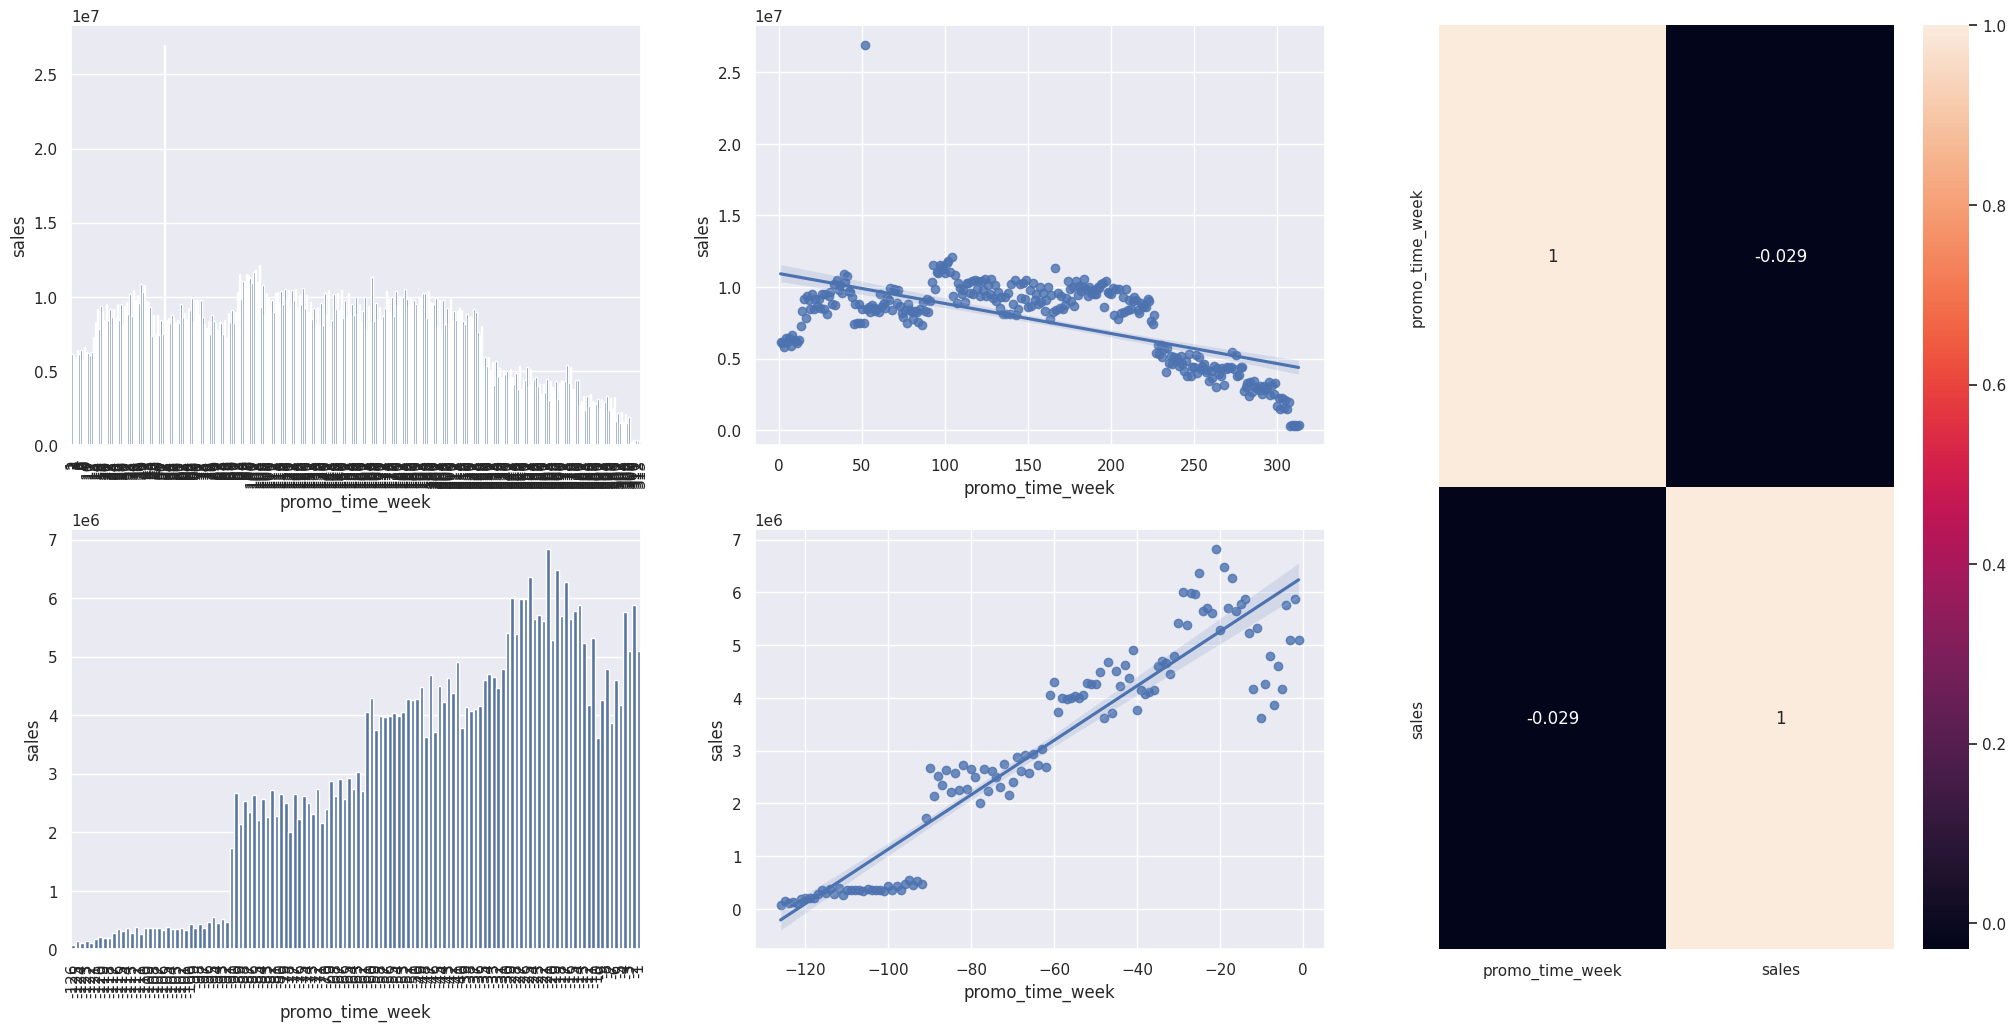

In [ ]:
# Summarize sales by promotion week
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec(2, 3)
# Subplot 1: Bar Plot for weeks with extended promo (promo_time_week > 0)
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

# Subplot 2: Regression Plot for weeks with extended promo
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

# Subplot 3: Bar Plot for weeks with regular promo (promo_time_week < 0)
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

# Subplot 4: Regression Plot for weeks with regular promo
plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# Subplot 5: Correlation Heatmap between promo time and sales
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# Interpretation of Promo Time vs. Sales:
# Extended promotions show high initial sales that decline over time, while regular promotions gain sales as they approach their end.
# Regression plots confirm these trends, with a weak negative correlation overall between promo time and sales.
# Conclusion: Extended promotions lose impact over time, whereas regular promotions grow more effective.

### 5.2.5 H5 Stores with more promotion days should sell more. FALSE

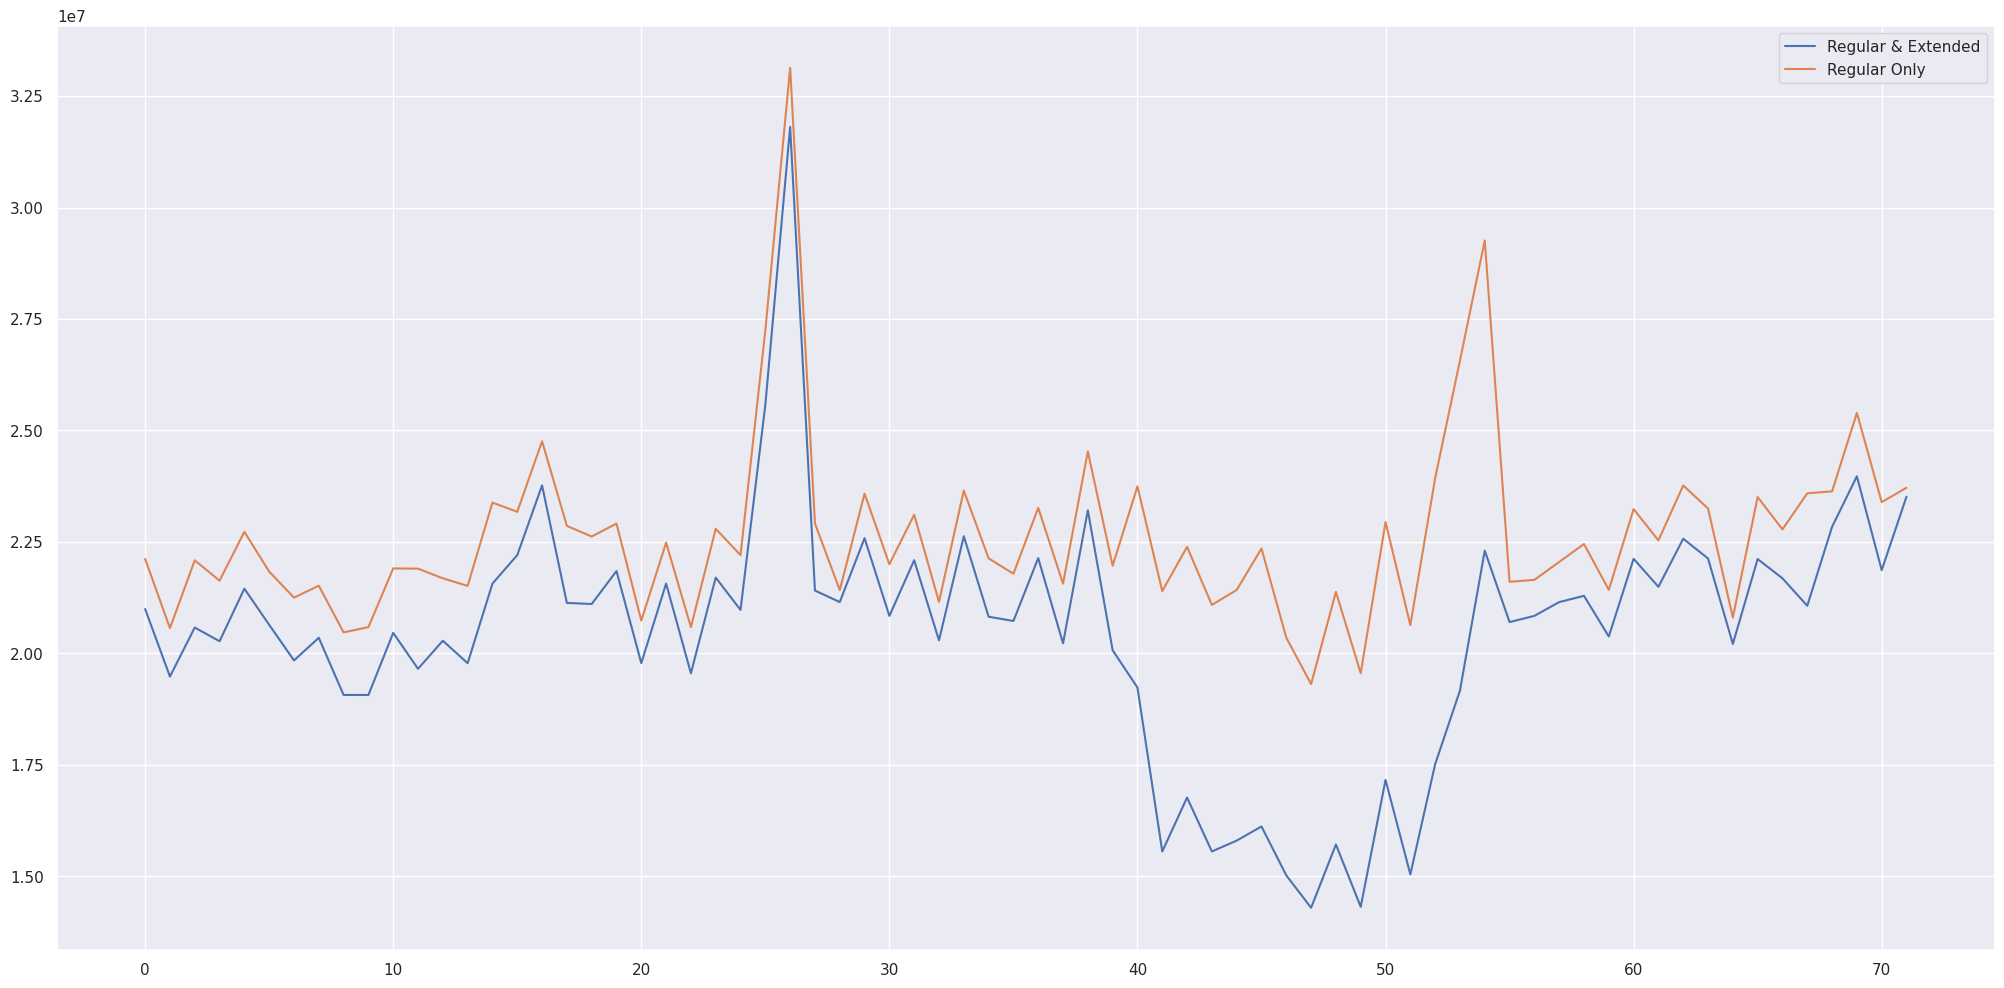

In [ ]:
# Summarize sales by 'promo' and 'promo2' to analyze the impact of promotions
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Filter sales data for weeks when both regular and extended promotions are active
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Filter sales data for weeks when only the regular promotion is active
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Plot sales trends over time for both scenarios
fig, ax = plt.subplots()
aux1.plot(ax=ax, label='Regular & Extended')
aux2.plot(ax=ax, label='Regular Only')

# Add legend to differentiate between regular and combined promotions
ax.legend(labels=['Regular & Extended', 'Regular Only'])
plt.show()

# Sales Trends: Regular-only promotions outperform when compared to combined regular & extended promotions.
# The orange line shows higher sales spikes, while the blue line indicates that adding an extended promotion may dilute the impact.
# Conclusion: Regular promotions alone are more effective in driving sales.


### 5.2.6 Stores should sell more on Christmans 

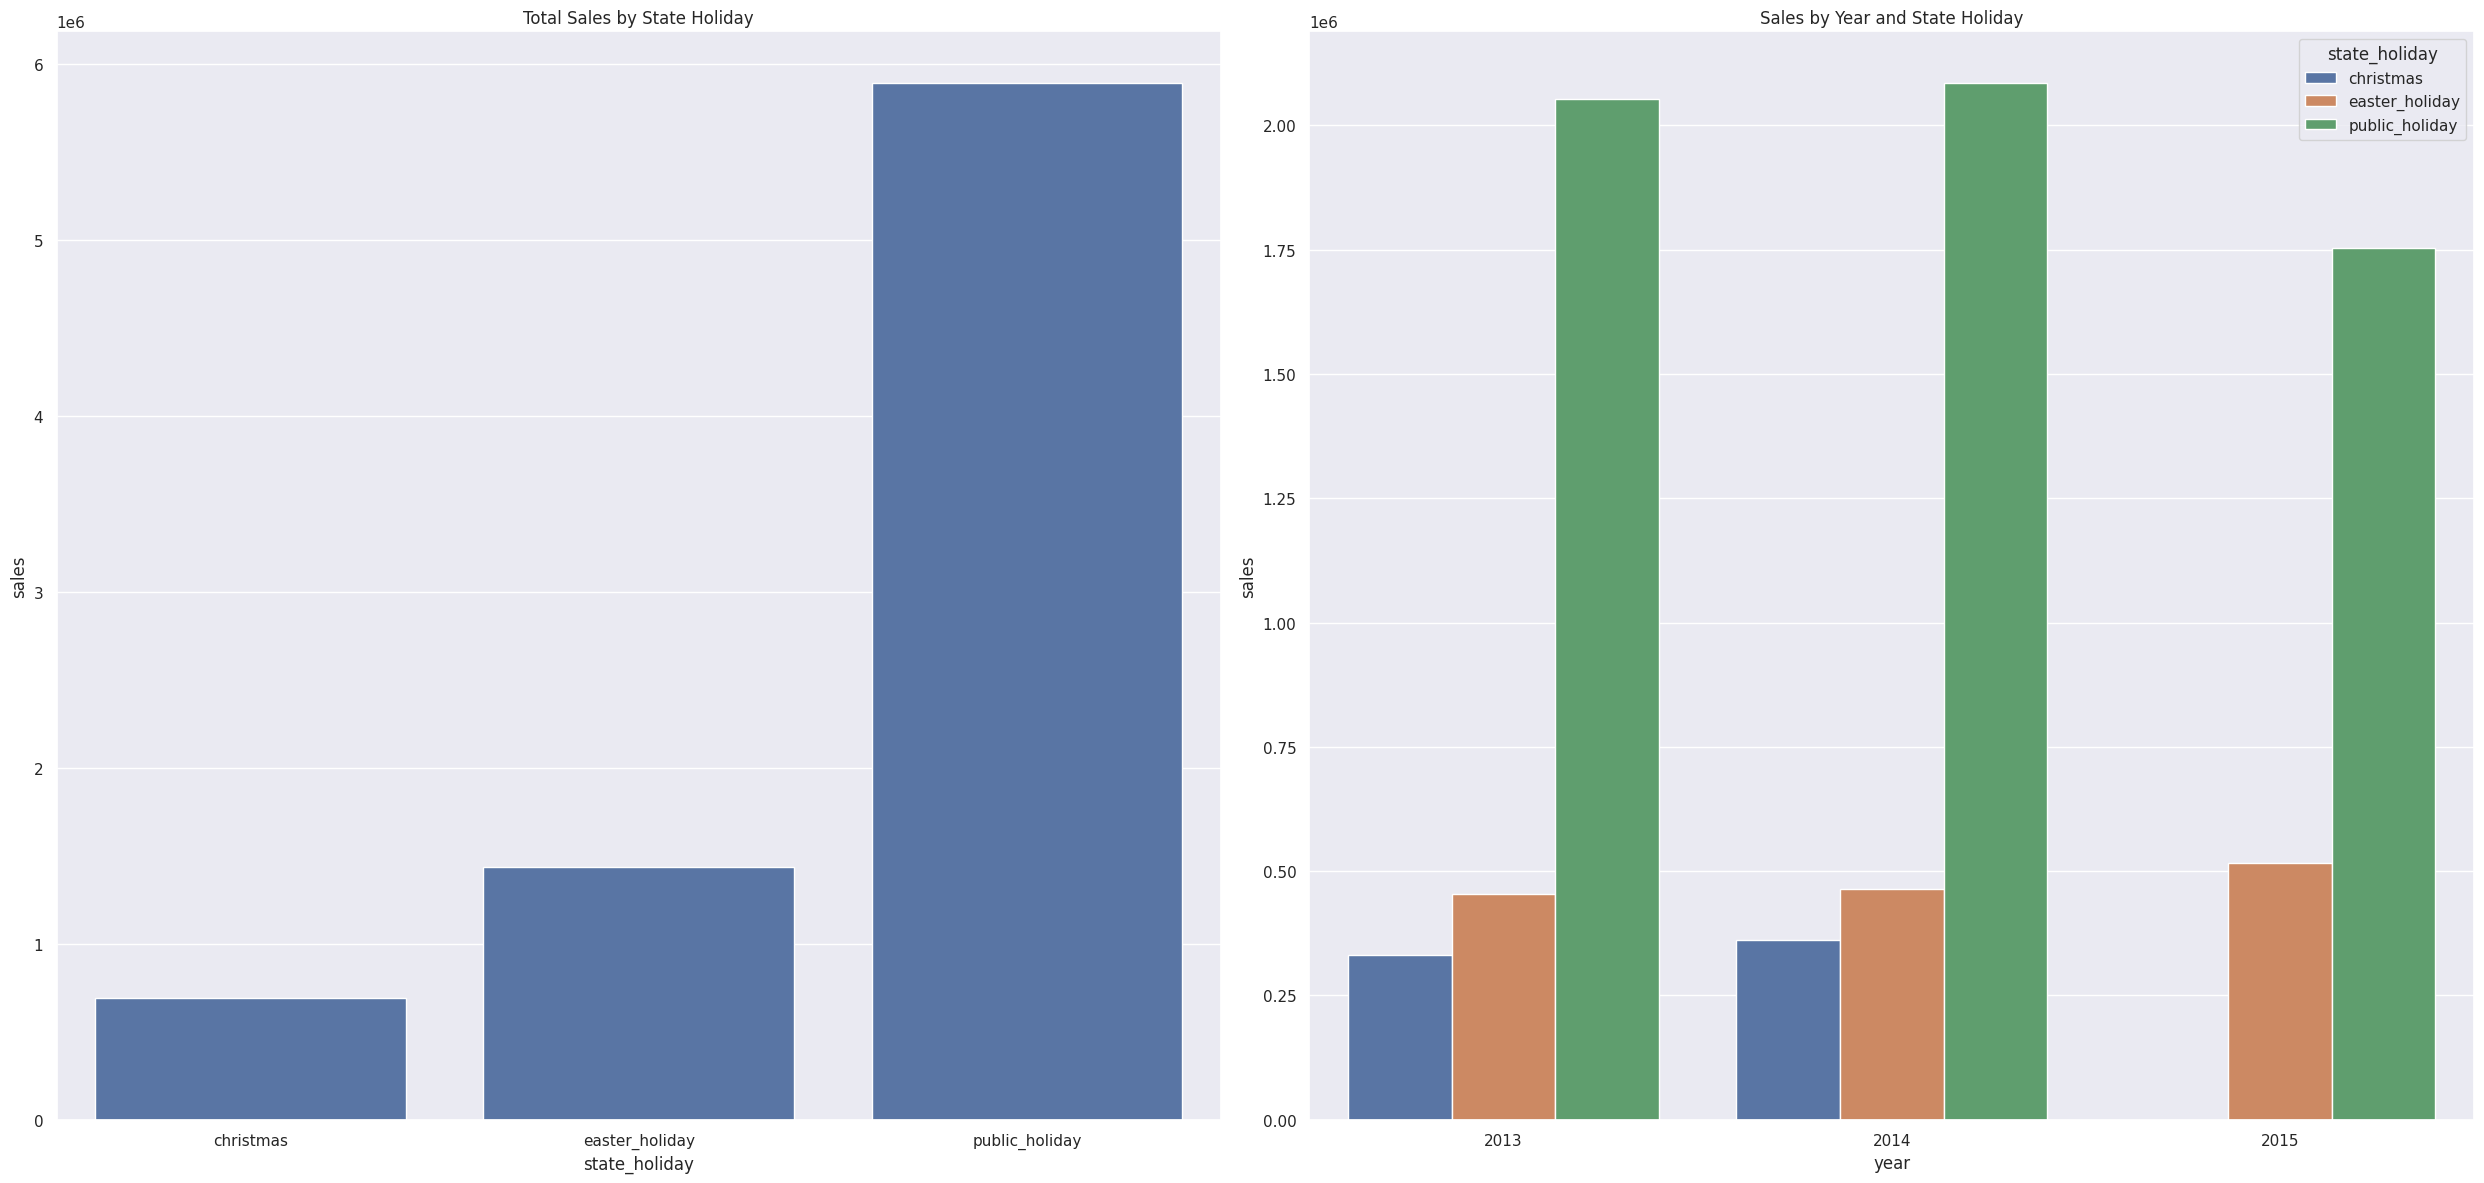

In [ ]:
# Filter out regular days to focus on sales during state holidays
aux = df4[df4['state_holiday'] != 'regular_day']

# Subplot 1: Total sales comparison across different state holidays
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title('Total Sales by State Holiday')

# Subplot 2: Annual sales trends for different state holidays
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.title('Sales by Year and State Holiday')

plt.tight_layout()
plt.show()

# Sales Trends by State Holiday:
# Public holidays generate the highest sales overall, significantly outperforming Christmas and Easter.
# The bar plot shows that sales during public holidays are consistently strong across all years, with 2013 having the peak.
# Conclusion: Public holidays are the most effective for driving sales, compared to specific holidays like Christmas and Easter.

### 3.2.7 H7 Stores should sell more over the years. FALSE

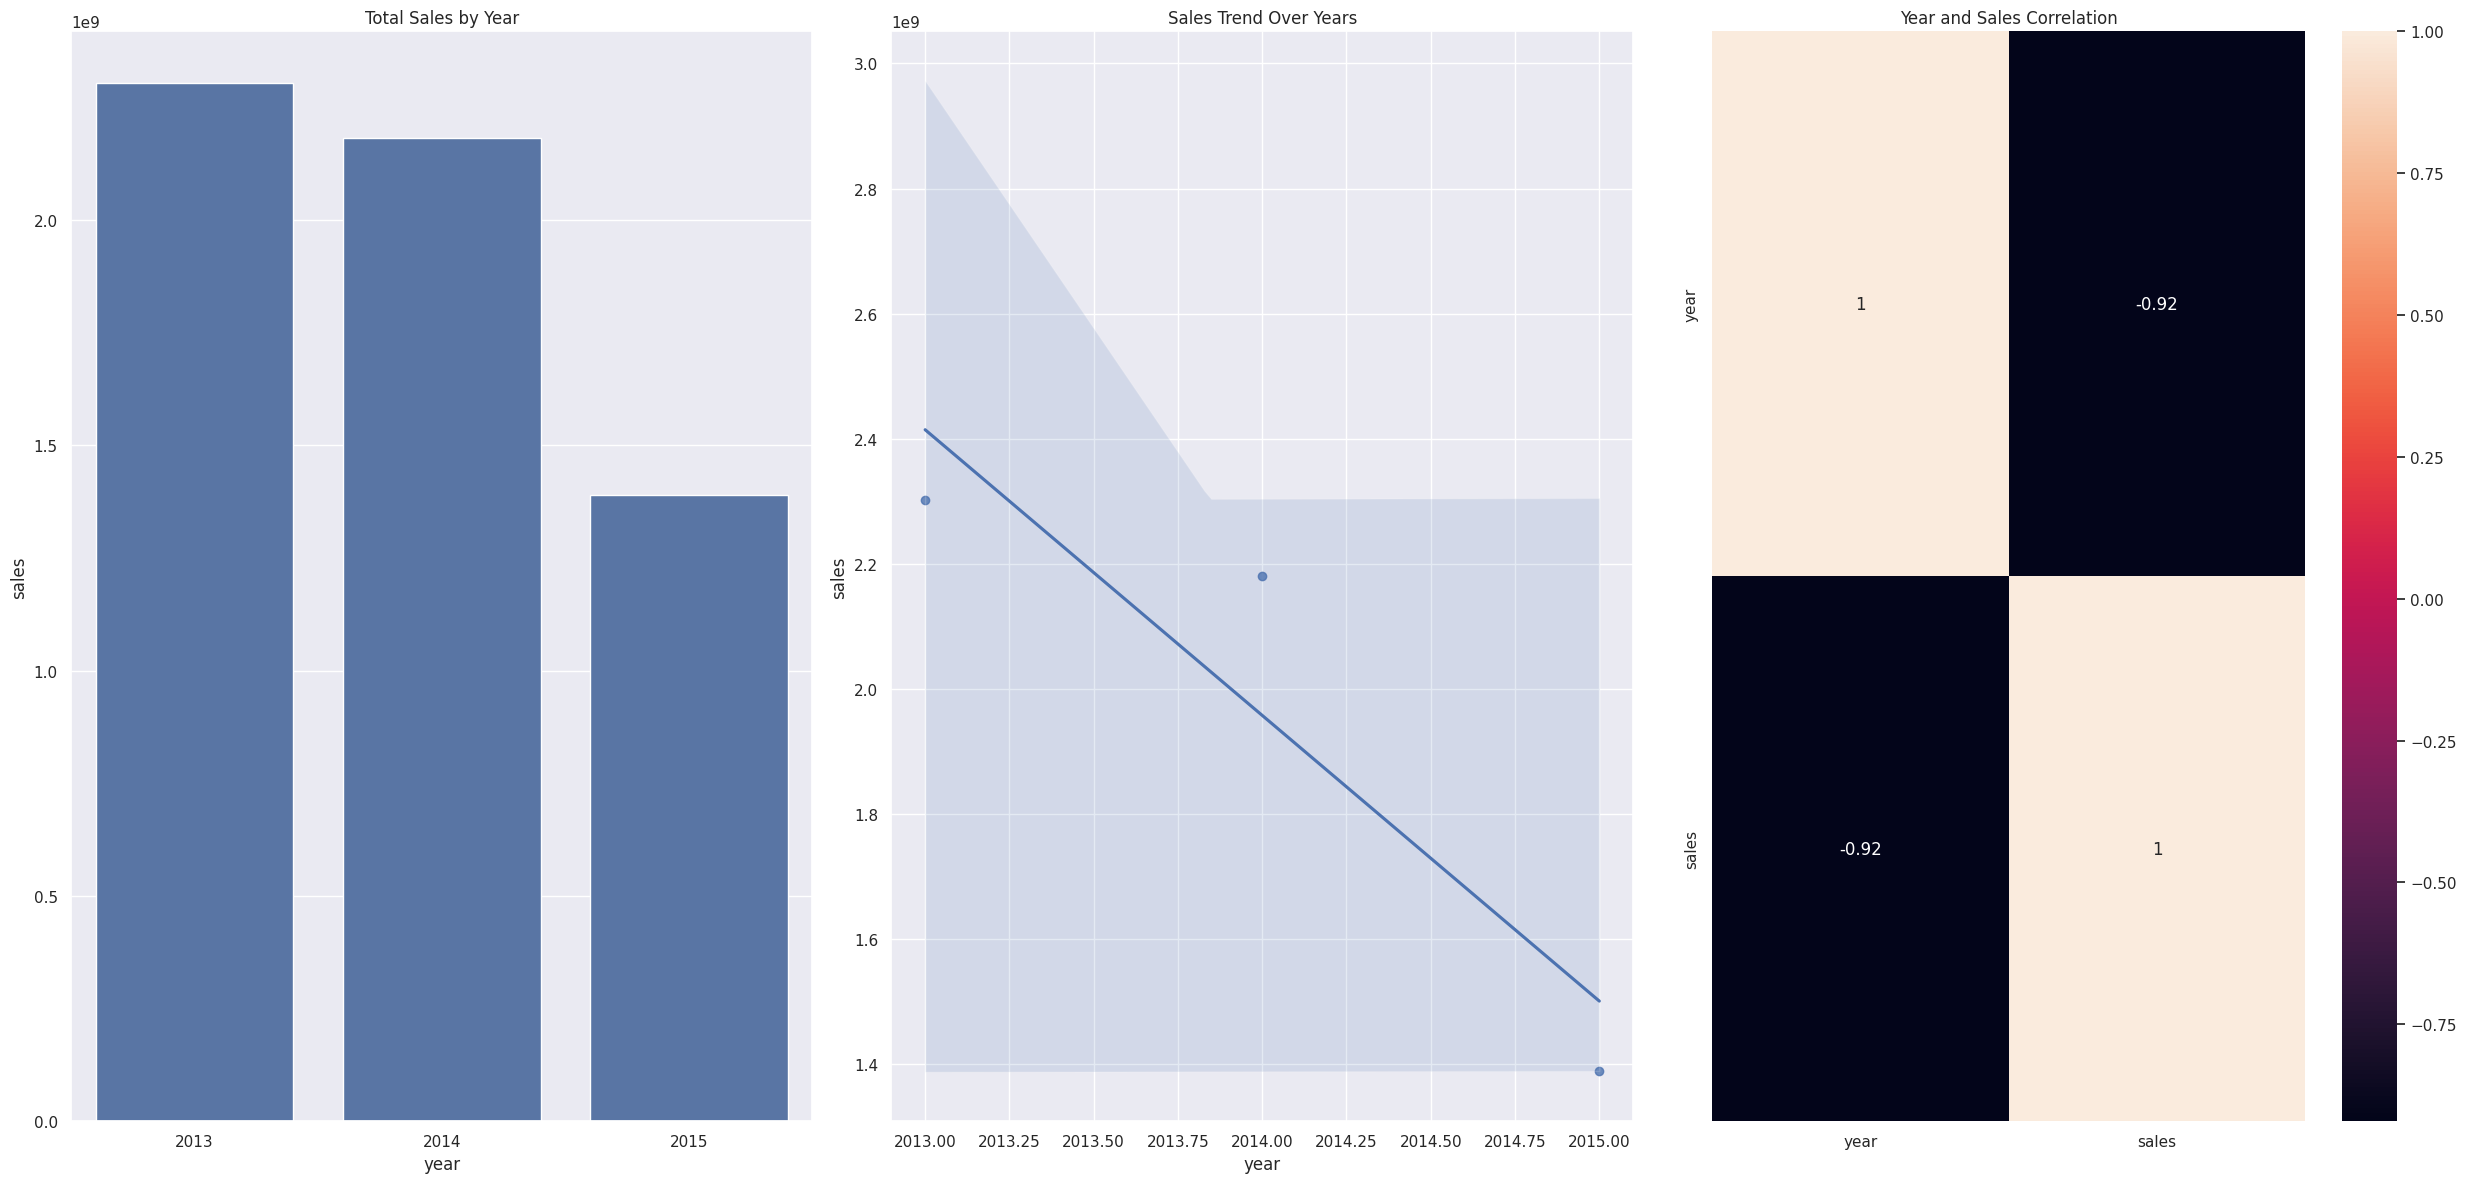

In [ ]:
# Summarize total sales by year
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Subplot 1: Total Sales by Year
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)
plt.title('Total Sales by Year')

# Subplot 2: Trend Analysis of Sales Over Years
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)
plt.title('Sales Trend Over Years')

# Subplot 3: Correlation Between Year and Sales
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Year and Sales Correlation')

plt.tight_layout()

# Sales Trends Over Years:
# Sales have decreased significantly from 2013 to 2015, as shown by both the bar plot and regression trend.
# The strong negative correlation confirms that sales are declining year over year.
# Conclusion: The hypothesis that stores should sell more over the years is false.


### 5.2.8 H8 Stores should sell more in the second half of the year. FALSE

Text(0.5, 1.0, 'Month and Sales Correlation')

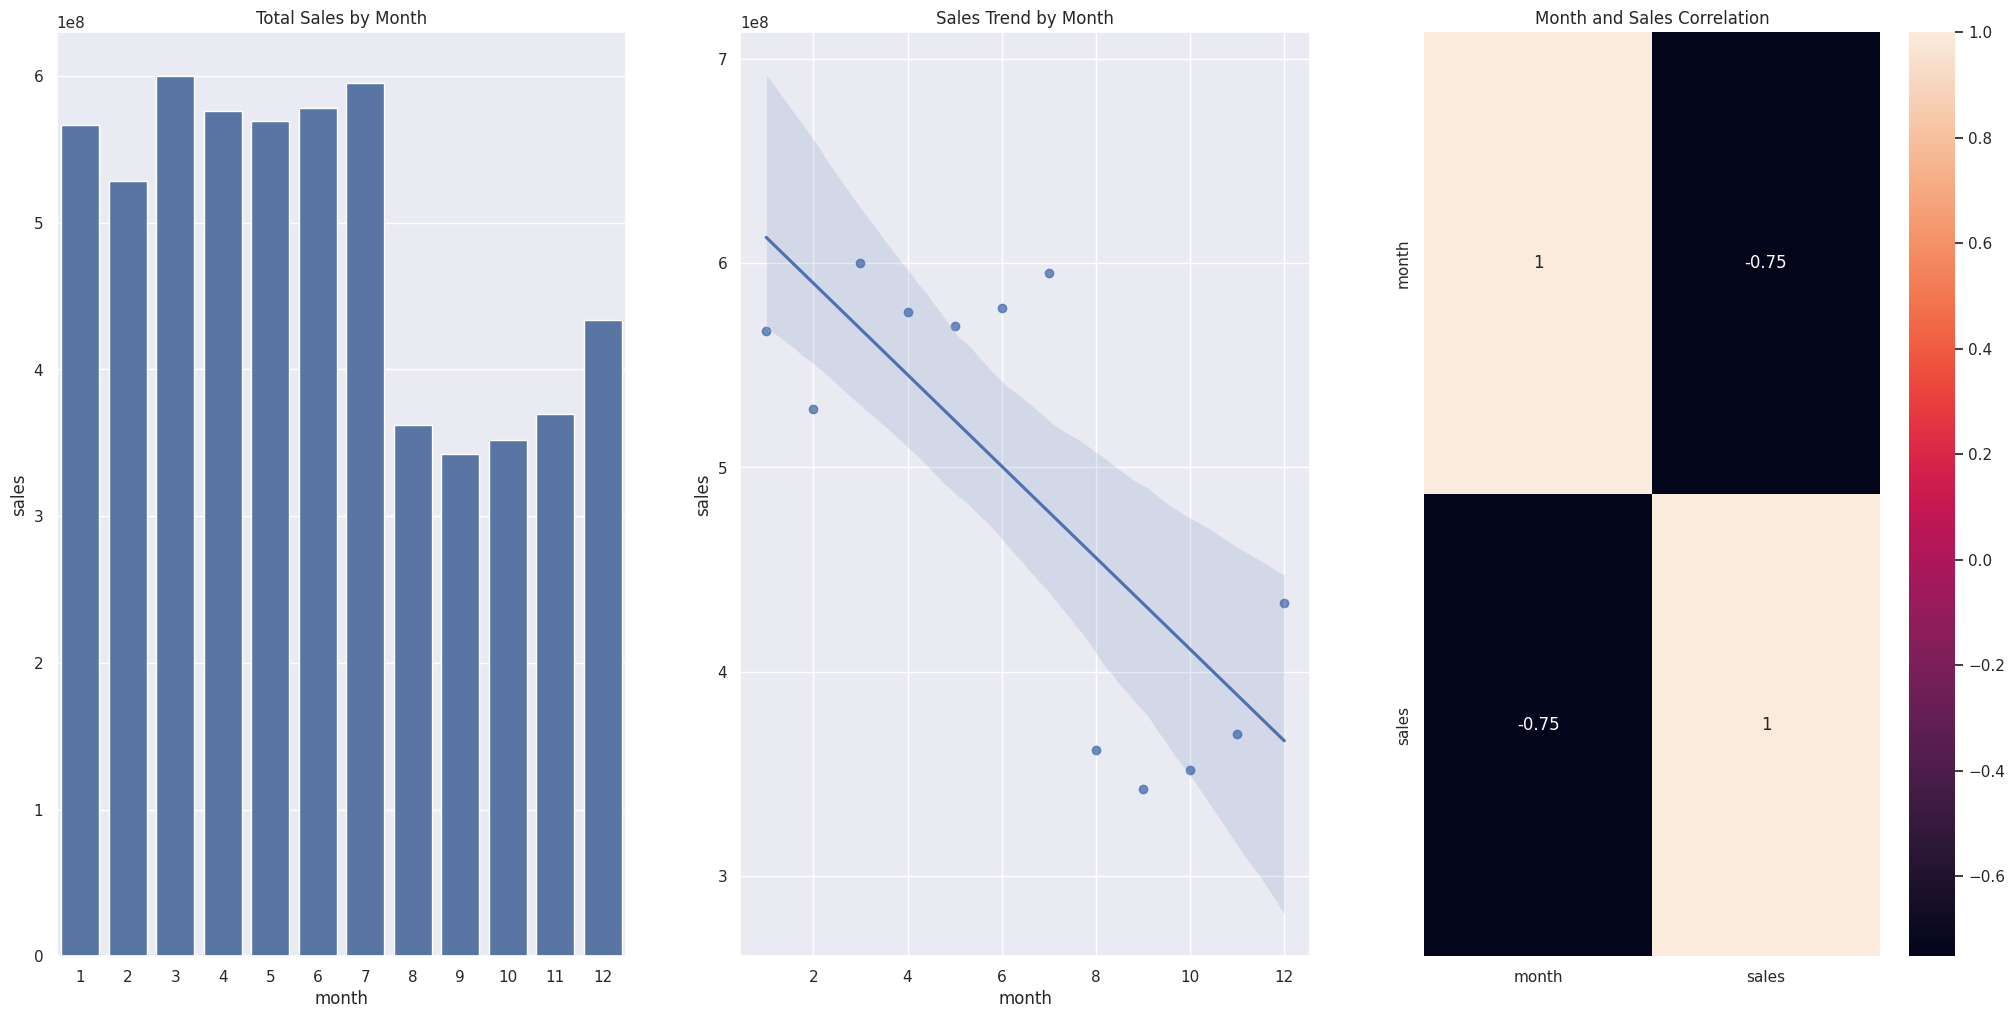

In [ ]:
# Summarize total sales by month
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Subplot 1: Total Sales by Month
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)
plt.title('Total Sales by Month')

# Subplot 2: Sales Trend Analysis by Month
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
plt.title('Sales Trend by Month')

# Subplot 3: Correlation Between Month and Sales
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Month and Sales Correlation')
# Sales Trends by Month:
# Sales peak in June and decline sharply from July to October.
# The regression and heatmap confirm a strong negative trend over the year.
# Conclusion: Sales drop as the year progresses, with early months being more profitable.

### 5.2.9 H9 Stores should sell more after the 10th of each month. TRUE

Text(0.5, 1.0, 'Sales Before and After 10 Days')

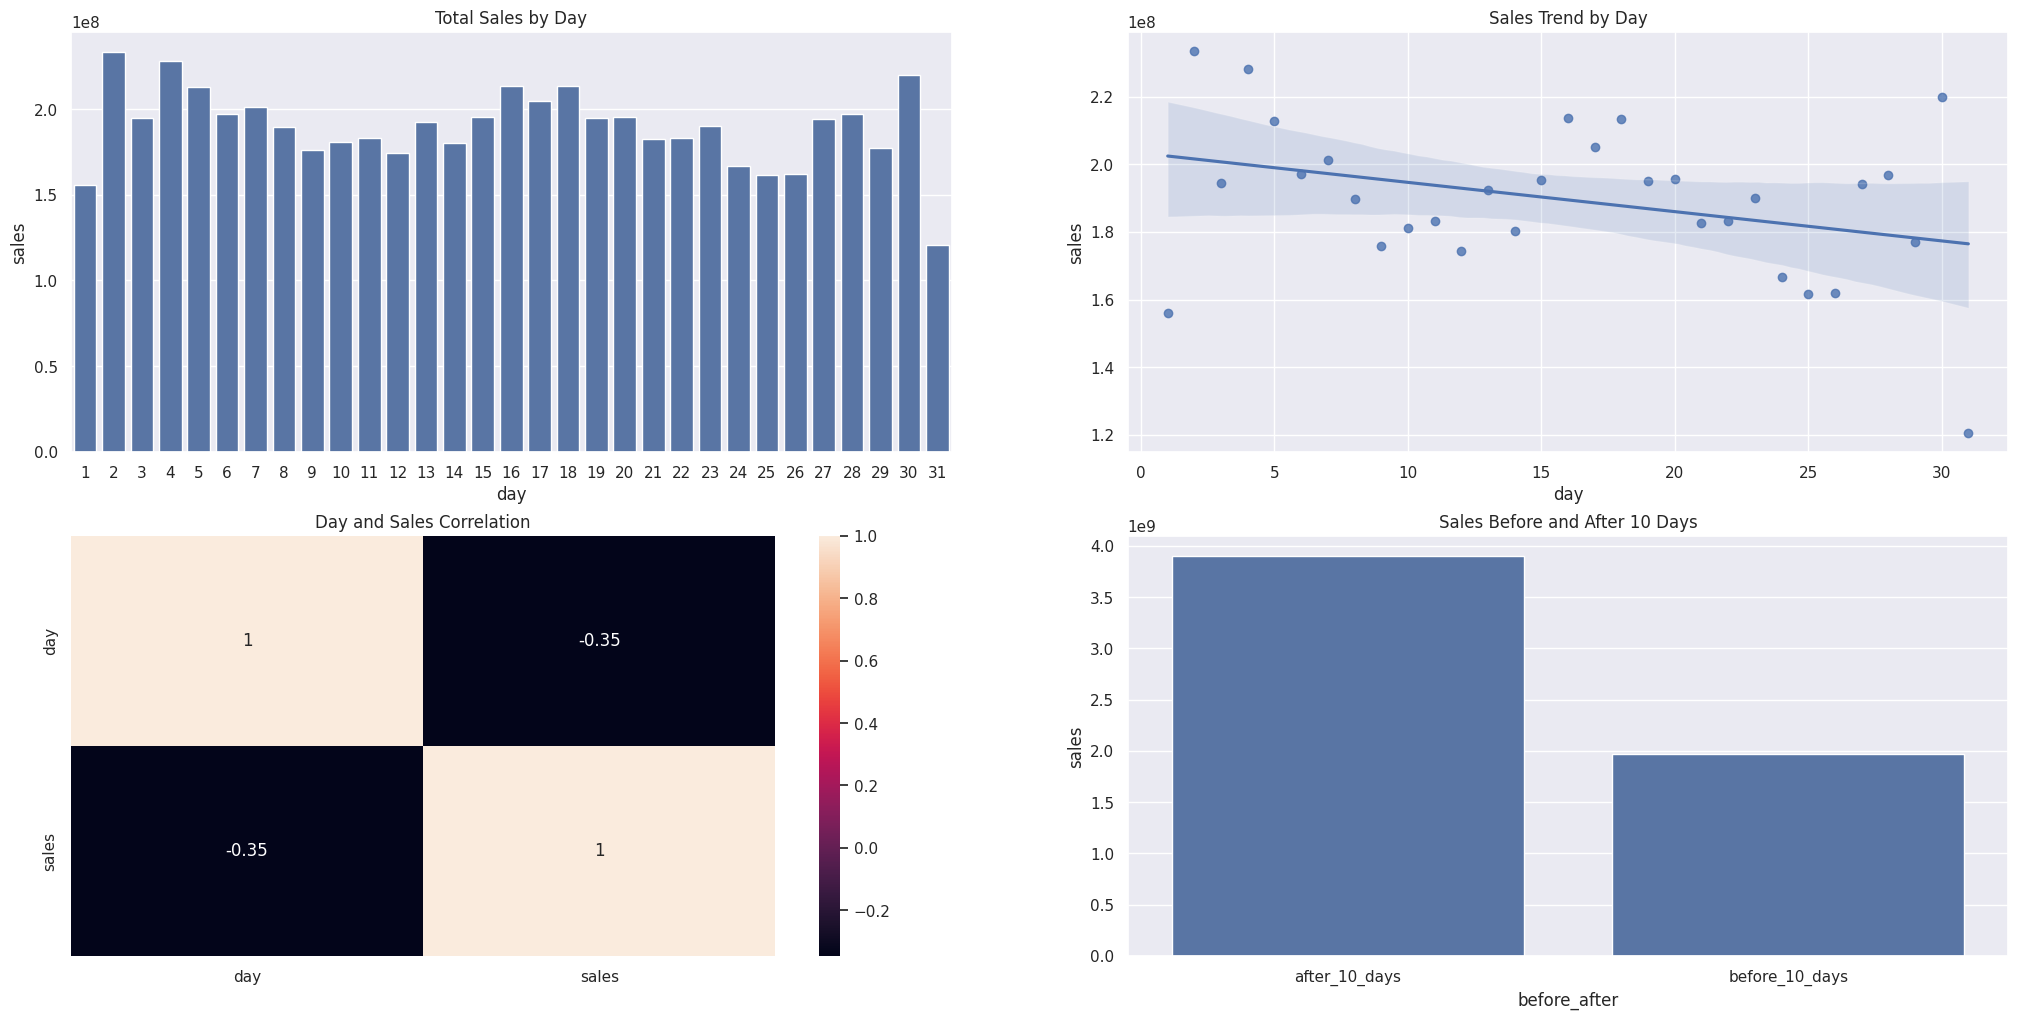

In [ ]:
# Summarize total sales by day of the month
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Subplot 1: Total Sales by Day
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Total Sales by Day')

# Subplot 2: Sales Trend by Day
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)
plt.title('Sales Trend by Day')

# Subplot 3: Correlation Between Day and Sales
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Day and Sales Correlation')

# Categorize days into 'before 10 days' and 'after 10 days'
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# Summarize sales before and after the 10th day of the month
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Subplot 4: Sales Before and After 10 Days
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.title('Sales Before and After 10 Days')

# Sales Trends by Day:
# Sales remain relatively stable with slight peaks on specific days, but tend to decline as the month progresses.
# Sales are notably higher after the 10th day of the month, as shown by the bar plot and correlation.
# Conclusion: Sales increase after the 10th day of the month, with a slight overall decline as the month progresses.

### 5.2.10 H10 Stores should sell less on weekends. TRUE


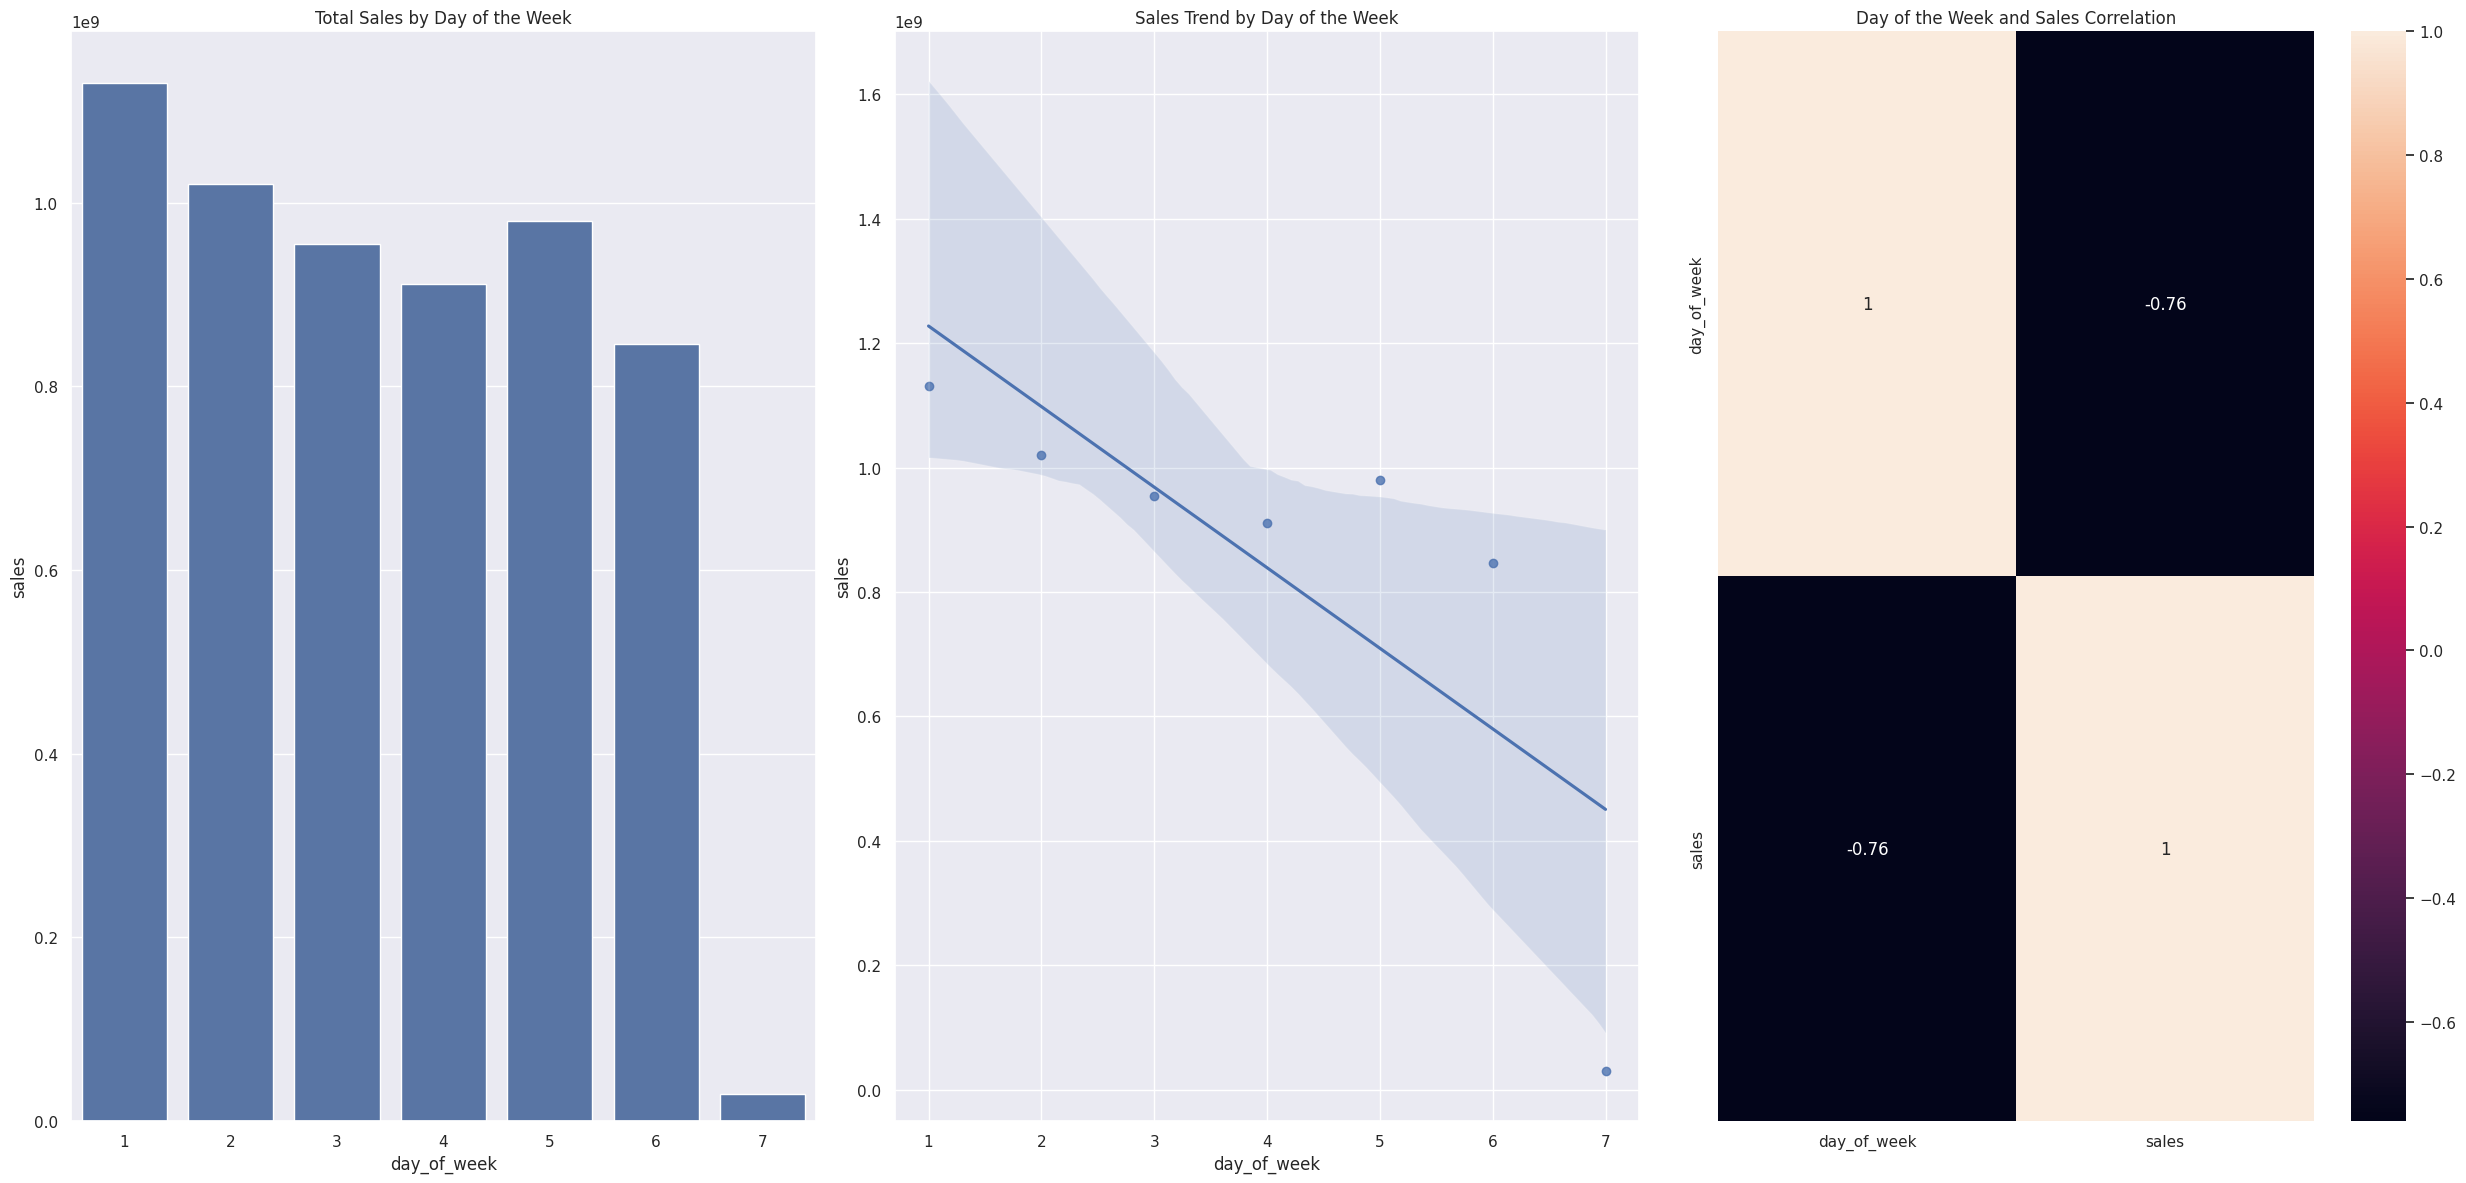

In [ ]:
# Create 'day_of_week' column to represent the day of the week (Monday=1, Sunday=7)
df4['day_of_week'] = df4['date'].dt.dayofweek + 1

# Summarize total sales by day of the week
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Subplot 1: Total Sales by Day of the Week
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.title('Total Sales by Day of the Week')

# Subplot 2: Sales Trend by Day of the Week
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.title('Sales Trend by Day of the Week')

# Subplot 3: Correlation Between Day of the Week and Sales
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Day of the Week and Sales Correlation')


plt.tight_layout()
plt.show()

# Sales Trends by Day of the Week:
# Sales peak on Mondays and decline steadily through the week, with the lowest sales on Sundays.
# The regression and correlation confirm a strong negative trend as the week progresses.
# Conclusion: Sales are strongest at the start of the week and drop significantly by the weekend.


### 5.2.11 H11 Stores should sell less during school holidays. True

Text(0.5, 1.0, 'Sales by Month and School Holiday')

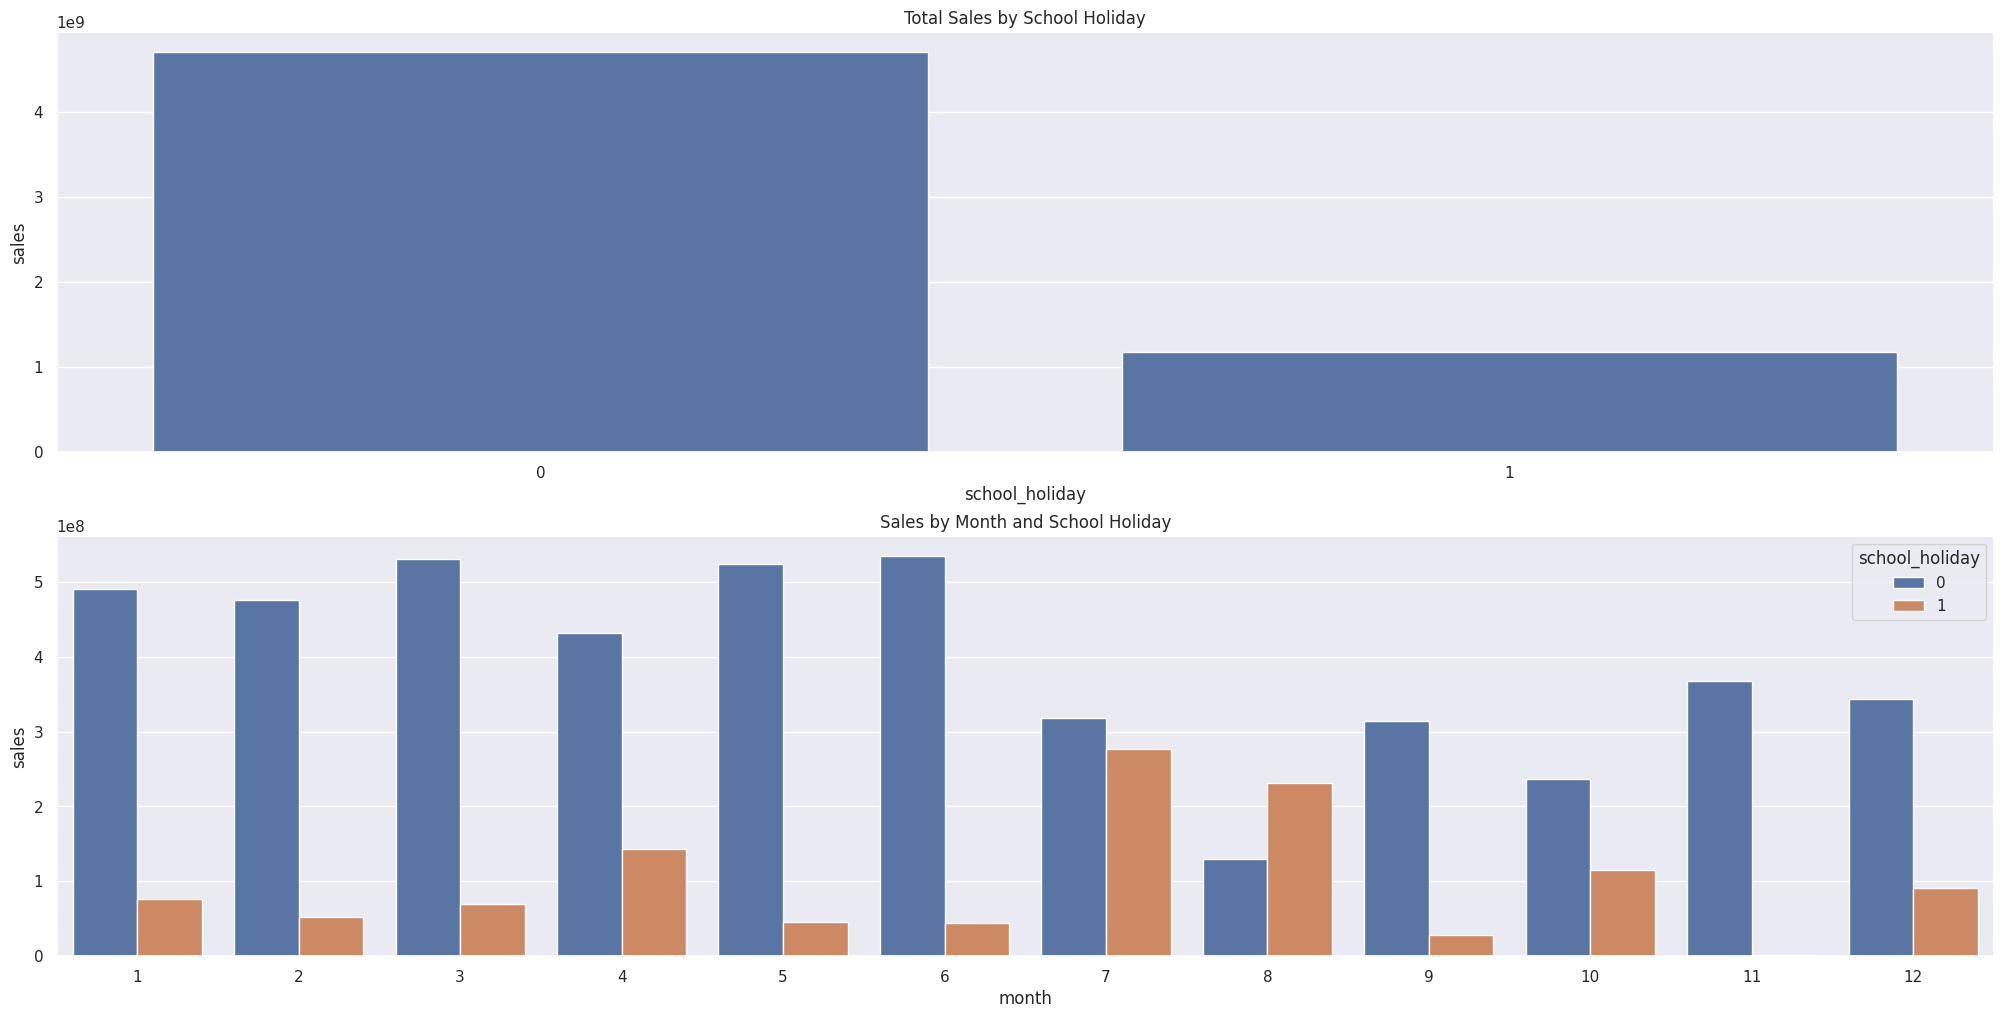

In [ ]:
# Summarize total sales by school holiday status
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Summarize sales by month and school holiday status
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Subplot 1: Total Sales by School Holiday Status
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title('Total Sales by School Holiday')

# Subplot 2: Sales by Month and School Holiday Status
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title('Sales by Month and School Holiday')

# Sales Impact of School Holidays:
# Sales are significantly lower during school holidays compared to non-school holidays.
# The trend is consistent across all months, with non-school holidays showing much higher sales.
# Conclusion: School holidays have a negative impact on sales.


### 5.2.13 Hipotheses Summary

In [ ]:
from tabulate import tabulate

tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H7', 'False', 'Low'],
       ['H8', 'False', 'Medium'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'High'],
       ['H13', 'True', 'Low']]

print(tabulate(tab, headers='firstrow'))


Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H7            False         Low
H8            False         Medium
H9            False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


## 5.3 Multivariable Analysis

### 5.3.1 Numerical Attributes

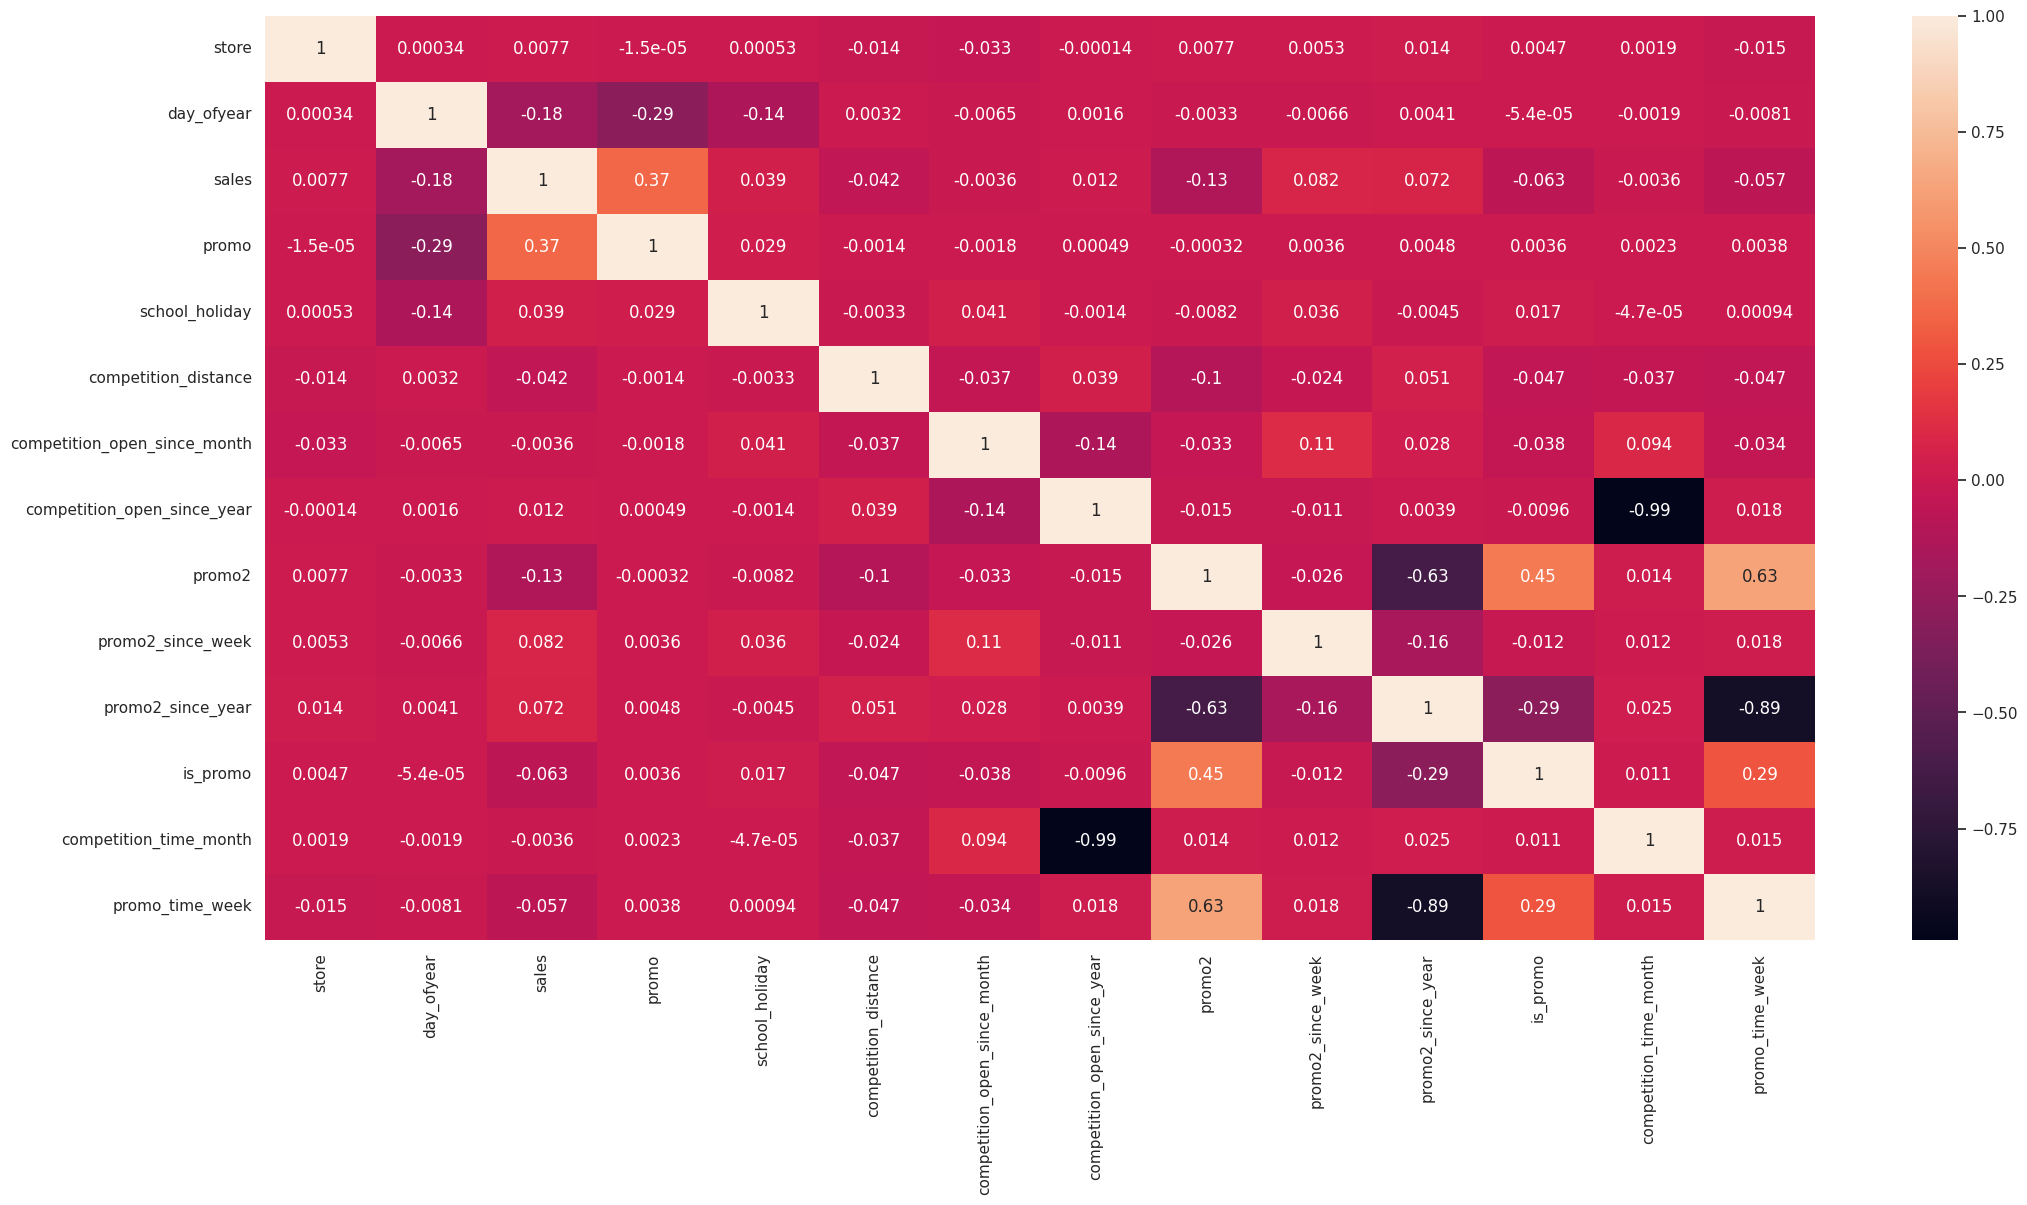

In [ ]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 5.3.2 Categorical Attributes

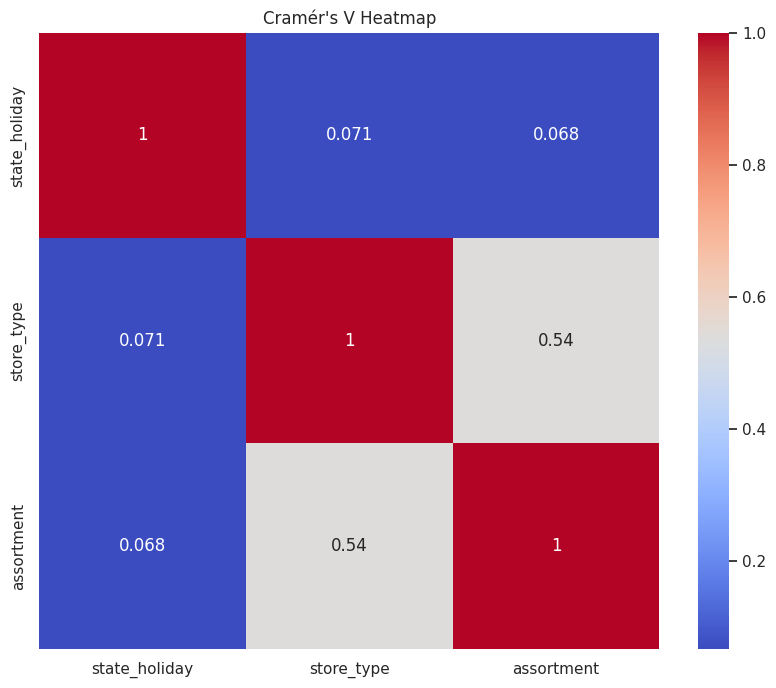

In [ ]:
# Select categorical data for Cramér's V analysis
a = df4.select_dtypes(include='object')

# Calculate Cramér's V for pairwise associations between categorical variables
a1 = cramers_v(a['state_holiday'], a['state_holiday'])  # Self-association for state_holiday
a2 = cramers_v(a['state_holiday'], a['store_type'])
a3 = cramers_v(a['state_holiday'], a['assortment'])
a4 = cramers_v(a['store_type'], a['state_holiday'])
a5 = cramers_v(a['store_type'], a['store_type'])  # Self-association for store_type
a6 = cramers_v(a['store_type'], a['assortment'])
a7 = cramers_v(a['assortment'], a['state_holiday'])
a8 = cramers_v(a['assortment'], a['store_type'])
a9 = cramers_v(a['assortment'], a['assortment'])  # Self-association for assortment

# Create a DataFrame to hold the Cramér's V values
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
})
d.index = ['state_holiday', 'store_type', 'assortment']

# Plot the Cramér's V heatmap to visualize the strength of associations
plt.figure(figsize=(10, 8))
sns.heatmap(d, annot=True, cmap='coolwarm')
plt.title("Cramér's V Heatmap")
plt.show()

# Cramér's V Analysis:
# There is a very weak association between state holidays and both store type and assortment.
# A moderate association exists between store type and assortment, suggesting some dependency between these variables.
# Conclusion: State holidays have minimal influence on store type or assortment, but store type and assortment are moderately related.


# 6 Data Preparation

## 6.1 Rescaling

In [ ]:
df5 = df4.copy()

# Instantiate scalers for data normalization
rs = RobustScaler()
mms = MinMaxScaler()

# Scale 'competition_distance' using RobustScaler and save the scaler
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)
with open("../parameter/robust_scaler_competition_distance.pkl", "wb") as file:
    pickle.dump(rs, file)

# Scale 'competition_time_month' using RobustScaler and save the scaler
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)
with open("../parameter/robust_scaler_competition_time_month.pkl", "wb") as file:
    pickle.dump(rs, file)

# Scale 'promo_time_week' using MinMaxScaler and save the scaler
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)
with open("../parameter/minmax_scaler_promo_time_week.pkl", "wb") as file:
    pickle.dump(mms, file)

# Scale 'year' using MinMaxScaler and save the scaler
df5["year"] = mms.fit_transform(df5[["year"]].values)
with open("../parameter/minmax_scaler_year.pkl", "wb") as file:
    pickle.dump(mms, file)


## 6.2 Transformation

### 6.2.1 Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

# store_type - Label Encoding
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])

# Save the LabelEncoder instance
with open("../parameter/label_encoder_store_type.pkl", "wb") as file:
    pickle.dump(le, file)

# assortment - Ordinal Encoding
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df5["assortment"] = df5["assortment"].map(assortment_dict)

### 6.2.2 Response Variable Transformation

In [ ]:
df5["sales"] = np.log1p(df5["sales"])

### 6.2.3 Nature Transformation

In [ ]:
# Day of Week Transformation
# Applying sine and cosine transformations to capture the cyclical nature of the week
df5["day_of_week_sin"] = df5["day_of_week"].apply(
    lambda x: np.sin(x * (2.0 * np.pi / 7))
)
df5["day_of_week_cos"] = df5["day_of_week"].apply(
    lambda x: np.cos(x * (2.0 * np.pi / 7))
)

# Month Transformation
# Applying sine and cosine transformations to capture the yearly seasonality
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2.0 * np.pi / 12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2.0 * np.pi / 12)))

# Day Transformation
# Applying sine and cosine transformations to capture the monthly periodicity
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))

# Week of Year Transformation
# Applying sine and cosine transformations to capture the yearly periodicity
df5["week_of_year_sin"] = df5["week_of_year"].apply(
    lambda x: np.sin(x * (2.0 * np.pi / 52))
)
df5["week_of_year_cos"] = df5["week_of_year"].apply(
    lambda x: np.cos(x * (2.0 * np.pi / 52))
)

# 7 Featuring Selection

## 7.1 Split dataframe into training and test dataset

In [ ]:
df6 = df5.copy()

# List of columns to be dropped
cols_drop = [
    "week_of_year",
    "day",
    "month",
    "day_of_week",
    "promo_since",
    "competition_since",
    "year_week",
]

# Drop the specified columns from the DataFrame
df6 = df6.drop(cols_drop, axis=1)

# Group by 'store' and find the latest date for each store
latest_dates = df6.groupby("store")["date"].max().reset_index()

# Subtract 6 weeks (42 days) from the latest date for each store
latest_dates["date_minus_6_weeks"] = latest_dates["date"] - datetime.timedelta(
    days=6 * 7
)

# Split the dataset into training and test sets
# Training dataset: dates before '2015-06-19'
X_train = df6[df6["date"] < "2015-06-19"]
y_train = X_train["sales"]

# Test dataset: dates on or after '2015-06-19'
X_test = df6[df6["date"] >= "2015-06-19"]
y_test = X_test["sales"]

# Print the date range for the training dataset
print("Training Min Date: {}".format(X_train["date"].min()))
print("Training Max Date: {}".format(X_train["date"].max()))

# Print the date range for the test dataset
print("\nTest Min Date: {}".format(X_test["date"].min()))
print("Test Max Date: {}".format(X_test["date"].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 7.2 Boruta as Feature Selector

In [ ]:
# # Prepare training data for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel() # This flattens the target variable y_train into a 1-dimensional array using ravel(). This is often necessary for compatibility with scikit-learn functions

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1) #use all cpu cores

# # Define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# # Fit Boruta
# boruta.fit(X_train_n, y_train_n) # This fits the Boruta model to the training data, determining which features are important.
# cols_selected = boruta.support_.tolist() # This retrieves a list of boolean values indicating which features were selected as important by Boruta.

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) #This again removes the date and sales columns from X_train but keeps the data in a DataFrame format.
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() #: This converts the list of boolean values into actual column names of the selected features.

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta )) #This determines the features that were not selected by Boruta by computing the set difference between all features and the selected features.

# print(cols_selected_boruta)
# print(cols_not_selected_boruta)

## 7.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist() # This retrieves a list of boolean values indicating which features were selected as important by Boruta.

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) #This again removes the date and sales columns from X_train but keeps the data in a DataFrame format.
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() #: This converts the list of boolean values into actual column names of the selected features.

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta )) #This determines the features that were not selected by Boruta by computing the set difference between all features and the selected features.

# print(cols_selected_boruta)
# print(cols_not_selected_boruta)

## 7.3 Manual Feature Selection

In [ ]:
cols_selected_boruta = [
    "store",
    "promo",
    "store_type",
    "assortment",
    "competition_distance",
    "competition_open_since_month",
    "competition_open_since_year",
    "promo2",
    "promo2_since_week",
    "promo2_since_year",
    "competition_time_month",
    "promo_time_week",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_cos",
    "day_sin",
    "day_cos",
    "week_of_year_cos",
]

cols_not_selected_boruta = [
    "is_promo",
    "month_sin",
    "school_holiday",
    "state_holiday_christmas",
    "state_holiday_easter_holiday",
    "state_holiday_public_holiday",
    "state_holiday_regular_day",
    "week_of_year_sin",
    "year",
]

# manual selected compare with hypostheses analises
cols_selected_boruta = [
    "store",
    "promo",
    "store_type",
    "assortment",
    "competition_distance",
    "competition_open_since_month",
    "competition_open_since_year",
    "promo2",
    "promo2_since_week",
    "promo2_since_year",
    "competition_time_month",
    "promo_time_week",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_sin",
    "month_cos",
    "day_sin",
    "day_cos",
    "week_of_year_sin",
    "week_of_year_cos",
]

# columns to add
feat_to_add = ["date", "sales"]
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8 Machine Learning Modeling

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 8.1 Average Model

In [ ]:
# Creating a DataFrame for the last 6 weeks for the boruta columns and adding 'date' and 'sales' from y_test
aux1 = x_test.copy()
aux1["sales"] = y_test.copy()

## prediction aux2 -> aux1 (using mean of sales)
aux2 = (
    aux1[["store", "sales"]]
    .groupby("store")
    .mean()
    .reset_index()
    .rename(columns={"sales": "predictions"})
)
aux1 = pd.merge(aux1, aux2, how="left", on="store")
yhat_baseline = aux1["predictions"]

# performance
# def ml_error( model_name, y, yhat ):
baseline_result = ml_error("Average Model", np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 8.2 Linear Regression Model

In [ ]:
# Training the Model
lr = LinearRegression().fit(x_train, y_train)

# # Fitting the Model: The fit() method trains the model using the training data (x_train and y_train).
# # x_train (df with boruta columns before 6 final weeks)
# y_train column sales before 6 final weeks

# Making Predictions
yhat_lr = lr.predict(x_test)
# Predicting: The predict() method uses the trained model to make predictions on the test data (x_test).
# lr: This is an instance of the LinearRegression class from scikit-learn. It represents a linear regression model that has already been trained using the fit() method with training data (x_train and y_train).
# Grouping by 'store' and calculating the mean sales for each store
# Renaming the 'sales' column to 'predictions' in the resulting DataFrame
# x_test: This is a DataFrame or array-like structure containing the test data. (last 6 weeks)

# Checking performance
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, "Linear Regression", lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 8.3 Linear Regression Regularized Model - Lasso

In [ ]:
# Training the Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Fitting the Model: The fit() method trains the model using the training data (x_train and y_train).
# x_train (df with boruta columns before 6 final weeks)
# y_train column sales before 6 final weeks

# Making Predictions
yhat_lrr = lrr.predict(x_test)
# Predicting: The predict() method uses the trained model to make predictions on the test data (x_test).
# lr: This is an instance of the LinearRegression class from scikit-learn. It represents a linear regression model that has already been trained using the fit() method with training data (x_train and y_train).
# Grouping by 'store' and calculating the mean sales for each store
# Renaming the 'sales' column to 'predictions' in the resulting DataFrame
# x_test: This is a DataFrame or array-like structure containing the test data. (last 6 weeks)

# Checking performance
lrr_result = ml_error("Linear Regression - Lasso", np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 8.3.1 Linear Regression Model - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, "Lasso", lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 8.4 Random Forest Regressor

In [ ]:
# Training the Model
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42).fit(
    x_train, y_train
)
# good RF have 2500 - 3000 estimators
# Making Predictions
yhat_rf = rf.predict(x_test)
# Checking performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,720.794124,0.106051,1069.261417


### 8.4.1 Random Forest Regressor - Cross Validation

In [ ]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
# rf_result_cv

## 8.5 XGBoost Regressor

In [ ]:
# Training the Model
model_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9,
).fit(x_train, y_train)

# Making Predictions
yhat_xgb = model_xgb.predict(x_test)

# Checking performance
xgb_result = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1367.023756,0.199689,2004.493719


### 8.5.1 XGBoost Regressor - Cross Validation

In [ ]:
gb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv

## 8.6 Compare Model’s Performance

### 8.6.1 Single Performance

In [ ]:
modelling_result = pd.concat(
    [baseline_result, lr_result, lrr_result, rf_result, xgb_result]
)
modelling_result.sort_values("RMSE")

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,720.794124,0.106051,1069.261417
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1367.023756,0.199689,2004.493719
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 8.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

NameError: name 'rf_result_cv' is not defined

# 9.0 HYPERPARAMETER FINE TUNING

## 9.1 Random Search

In [ ]:
# param = {
# 'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }
#
# MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()
#
# for i in range( MAX_EVAL ):
# # choose values for parameters randomly
# hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
# print( hp )

# # model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
# n_estimators=hp['n_estimators'],
# eta=hp['eta'],
# max_depth=hp['max_depth'],
# subsample=hp['subsample'],
# colsample_bytee=hp['colsample_bytree'],
# min_child_weight=hp['min_child_weight']

# # performance
# result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,␣֒→verbose=True )
# final_result = pd.concat( [final_result, result] )
#
# final_result

## 9.2 Final Model

In [ ]:
param_tuned = {
    "n_estimators": 3000,
    "eta": 0.03,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "min_child_weight": 3,
}

In [ ]:
model_xgb_tuned = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=param_tuned["n_estimators"],
    eta=param_tuned["eta"],
    max_depth=param_tuned["max_depth"],
    subsample=param_tuned["subsample"],
    colsample_bytree=param_tuned["colsample_bytree"],
    min_child_weight=param_tuned["min_child_weight"],
).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error(
    "XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb_tuned)
)
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,777.043668,0.116216,1123.594037


In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

np.float64(-0.01588868408215251)

In [ ]:
# Save the trained model to a file
with open("../model/model_rossmann.pkl", "wb") as file:
    pickle.dump(model_xgb_tuned, file)

# 10.0 Error Analysis

In [ ]:
# Create a new DataFrame df9 from selected columns in X_test
df9 = X_test[cols_selected_boruta_full].copy()

# Rescale 'sales' and assign to the DataFrame
df9.loc[:, "sales"] = np.expm1(df9["sales"])

# Rescale 'predictions' and assign to the DataFrame
df9.loc[:, "predictions"] = np.expm1(yhat_xgb_tuned)

## 10.1 Business Performance


In [ ]:
# Sum of predictions
# Grouping by 'store' and summing the 'predictions' column, then resetting the index for a clean DataFrame
df91 = df9[["store", "predictions"]].groupby("store").sum().reset_index()

# Calculate MAE (Mean Absolute Error)
# Grouping by 'store' and applying the mean_absolute_error function to calculate the MAE for each store
df9_aux1 = (
    df9.groupby("store", group_keys=False)
    .apply(
        lambda x: mean_absolute_error(x["sales"], x["predictions"]),
        include_groups=False,
    )
    .reset_index()
    .rename(columns={0: "MAE"})
)

# Calculate MAPE (Mean Absolute Percentage Error)
# Grouping by 'store' and applying the mean_absolute_percentage_error function to calculate the MAPE for each store
df9_aux2 = (
    df9.groupby("store", group_keys=False)
    .apply(
        lambda x: mean_absolute_percentage_error(x["sales"], x["predictions"]),
        include_groups=False,
    )
    .reset_index()
    .rename(columns={0: "MAPE"})
)

# Merge MAE and MAPE results
# Merging the two DataFrames (MAE and MAPE) on the 'store' column
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how="inner", on="store")

# Merge the sum of predictions with MAE and MAPE results
# Merging the sum of predictions DataFrame (df91) with the combined MAE and MAPE DataFrame (df9_aux3) on the 'store' column
df92 = pd.merge(df91, df9_aux3, how="inner", on="store")

# Calculate scenarios
# Calculating the worst case scenario by subtracting MAE from predictions
df92["worst_scenario"] = df92["predictions"] - df92["MAE"]
# Calculating the best case scenario by adding MAE to predictions
df92["best_scenario"] = df92["predictions"] + df92["MAE"]

# Order columns
# Reordering the columns of the final DataFrame for better readability
df92 = df92[["store", "predictions", "worst_scenario", "best_scenario", "MAE", "MAPE"]]

# Display the final DataFrame
# Printing the final DataFrame to view the results
print(df92)

      store    predictions  worst_scenario  best_scenario          MAE      MAPE
0         1  172346.890625   171951.038535  172742.742715   395.852090  0.090044
1         2  184567.968750   184107.578739  185028.358761   460.390011  0.093628
2         3  266553.906250   265902.995526  267204.816974   650.910724  0.089955
3         4  337803.156250   336827.346152  338778.966348   975.810098  0.092741
4         5  169926.765625   169573.570695  170279.960555   353.194930  0.077026
5         6  183452.046875   182951.823414  183952.270336   500.223461  0.111410
6         7  339069.562500   338159.265493  339979.859507   910.297007  0.090982
7         8  202549.437500   201633.398134  203465.476866   916.039366  0.132454
8         9  264955.968750   264341.406039  265570.531461   614.562711  0.081152
9        10  206248.453125   205585.905570  206911.000680   662.547555  0.113408
10       11  288458.468750   287820.633222  289096.304278   637.835528  0.089223
11       12  281455.937500  

In [ ]:
# Display the top stores with the highest MAPE
# Sorting the DataFrame by MAPE in descending order and displaying the top rows
df92.sort_values("MAPE", ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105687.914062,102281.250450,109094.577675,3406.663613,0.593064
908,909,220616.468750,212672.715778,228560.221722,7943.752972,0.522000
594,595,323519.968750,317960.697318,329079.240182,5559.271432,0.383606
901,902,199952.734375,198546.119932,201359.348818,1406.614443,0.351834
875,876,197488.328125,193470.734067,201505.922183,4017.594058,0.323056


<Axes: xlabel='store', ylabel='MAPE'>

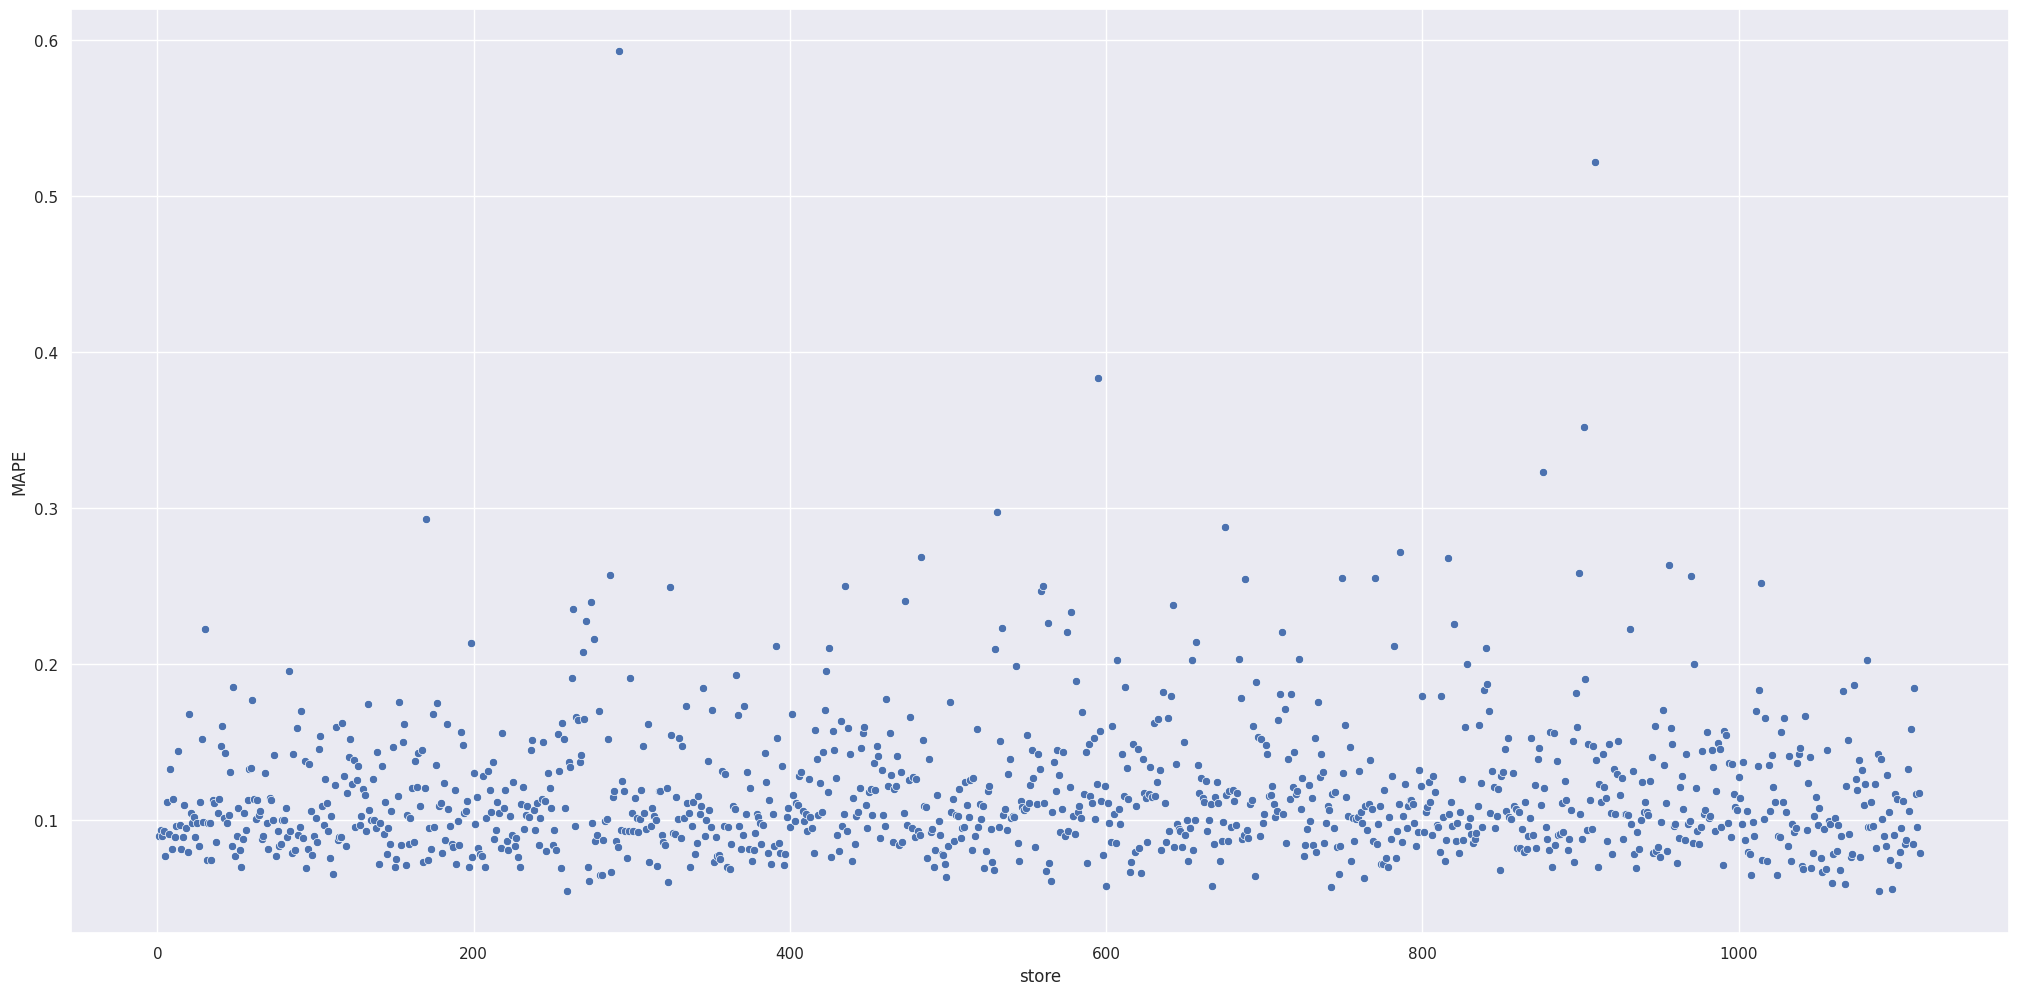

In [ ]:
# Plotting a scatter plot
# Creating a scatter plot to visualize the relationship between 'store' and 'MAPE' using Seaborn
sns.scatterplot(x="store", y="MAPE", data=df92)

##  10.2 Total Performance

In [ ]:
# Aggregating predictions and scenarios
# Selecting the columns 'predictions', 'worst_scenario', and 'best_scenario' from df92
# Applying the sum function along the rows (axis=0) to aggregate the values
# Resetting the index to convert the Series to a DataFrame
# Renaming the columns for better readability
df93 = (
    df92[["predictions", "worst_scenario", "best_scenario"]]
    .apply(lambda x: np.sum(x), axis=0)
    .reset_index()
    .rename(columns={"index": "Scenario", 0: "Values"})
)

# Formatting the 'Values' column
# Mapping the 'Values' column to a string format with currency representation 'R${:,.2f}'
df93["Values"] = df93["Values"].map("R${:,.2f}".format)

# Displaying the final DataFrame
# Printing df93 to view the aggregated and formatted results
df93

,Scenario,Values
0,predictions,"R$286,018,880.00"
1,worst_scenario,"R$285,149,419.25"
2,best_scenario,"R$286,888,364.56"


## 10.3 Machine Learning Performance

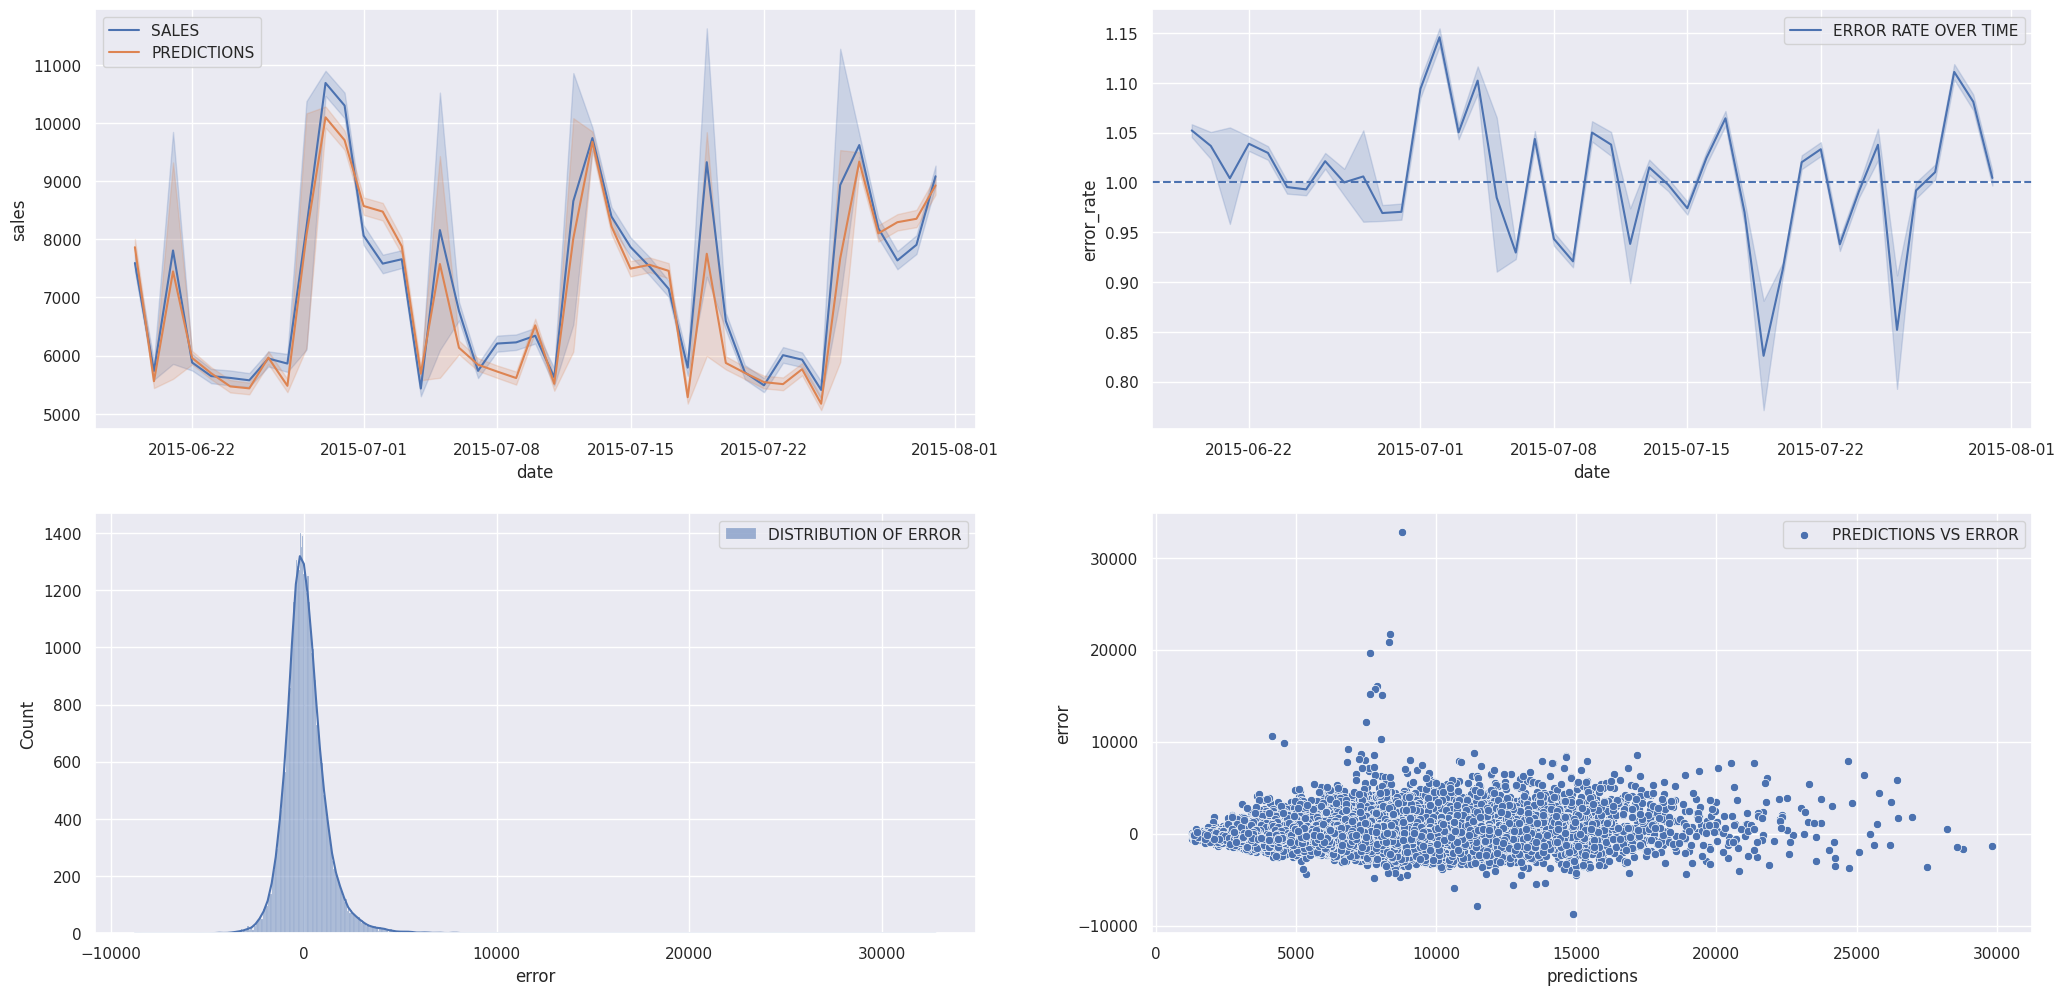

In [ ]:
# Calculate error and error rate
# Adding a new column 'error' to df9 which is the difference between 'sales' and 'predictions'
df9["error"] = df9["sales"] - df9["predictions"]

# Adding a new column 'error_rate' to df9 which is the ratio of 'predictions' to 'sales'
df9["error_rate"] = df9["predictions"] / df9["sales"]

# Create subplots
# Creating a subplot with 2 rows and 2 columns for different plots
plt.subplot(2, 2, 1)

# Plot sales and predictions over time
# Plotting a line plot of 'sales' over 'date' with a label 'SALES'
sns.lineplot(x="date", y="sales", data=df9, label="SALES")

# Plotting a line plot of 'predictions' over 'date' with a label 'PREDICTIONS'
sns.lineplot(x="date", y="predictions", data=df9, label="PREDICTIONS")

# Create the second subplot
plt.subplot(2, 2, 2)

# Plot error rate over time
# Plotting a line plot of 'error_rate' over 'date'
sns.lineplot(x="date", y="error_rate", data=df9, label="ERROR RATE OVER TIME")

# Adding a horizontal line at y=1 with a dashed linestyle
plt.axhline(1, linestyle="--")

# Create the third subplot
plt.subplot(2, 2, 3)

# Plot distribution of errors
# Plotting the distribution of 'error' using a histogram and KDE
sns.histplot(df9["error"], kde=True, label="DISTRIBUTION OF ERROR")

# Display the legend
plt.legend()

# Create the fourth subplot
plt.subplot(2, 2, 4)

# Plot predictions vs. errors
# Creating a scatter plot of 'predictions' against 'error'
sns.scatterplot(x="predictions", y="error", label="PREDICTIONS VS ERROR", data=df9)

# Display the legend
plt.legend()

# Display the plots
plt.show()

# 11.0 Deploy Model to Production      

## 11.1 Rossmann Class        

In [ ]:
# Create Class: need to save the transformation in a pickle to apply the same transformation to new data incoming


class rossmann(object):
    def __init__(self):
        self.home_path = "/home/thiago_souza/project_cds/rossmann_case/"
        # Load the RobustScaler for 'competition_distance'
        self.robust_scaler_competition_distance = pickle.load(
            open(
                self.home_path + "parameter/robust_scaler_competition_distance.pkl",
                "rb",
            )
        )

        # Load the RobustScaler for 'competition_time_month'
        self.robust_scaler_competition_time_month = pickle.load(
            open(
                self.home_path + "parameter/robust_scaler_competition_time_month.pkl",
                "rb",
            )
        )

        # Load the MinMaxScaler for 'promo_time_week'
        self.minmax_scaler_promo_time_week = pickle.load(
            open(self.home_path + "parameter/minmax_scaler_promo_time_week.pkl", "rb")
        )

        # Load the MinMaxScaler for 'year'
        self.minmax_scaler_year = pickle.load(
            open(self.home_path + "parameter/minmax_scaler_year.pkl", "rb")
        )

        # Load the LabelEncoder for 'store_type'
        self.label_encoder_store_type = pickle.load(
            open(self.home_path + "parameter/label_encoder_store_type.pkl", "rb")
        )

    def data_cleanning(self, df1):
        # List of original column names removed columns customer and sales
        cols_old = [
            "Store",
            "DayOfWeek",
            "Date",
            "Open",
            "Promo",
            "StateHoliday",
            "SchoolHoliday",
            "StoreType",
            "Assortment",
            "CompetitionDistance",
            "CompetitionOpenSinceMonth",
            "CompetitionOpenSinceYear",
            "Promo2",
            "Promo2SinceWeek",
            "Promo2SinceYear",
            "PromoInterval",
        ]

        # Lambda function to convert camel case to snake case
        snakecase = lambda x: inflection.underscore(x)

        # Apply the function to each column name in cols_old
        cols_new = list(map(snakecase, cols_old))

        # Rename the columns of the DataFrame
        df1.columns = cols_new

        # Convert the 'date' column in df1 to datetime format
        df1["date"] = pd.to_datetime(df1["date"])

        # competition_distance
        df1["competition_distance"] = df1["competition_distance"].apply(
            lambda x: 200000.0 if math.isnan(x) else x
        )
        # Business Context: The chosen value (200000.0 in this case) is an assumptions. If the competition distance is unknown, is reasonable to assume it is very high, indicating no nearby competition.

        # Replace NaN values in 'competition_open_since_month' with the month from 'date'
        df1["competition_open_since_month"] = df1.apply(
            lambda x: (
                x["date"].month
                if math.isnan(x["competition_open_since_month"])
                else x["competition_open_since_month"]
            ),
            axis=1,
        )
        # Replacing NaN values in the competition_open_since_month column with the month extracted from the date column is a pragmatic solution to ensure data completeness, maintain temporal consistency, and avoid biases, ultimately leading to more reliable and insightful business analyses and decisions.

        # Replace NaN values in 'competition_open_since_year' with the year from 'date'
        df1["competition_open_since_year"] = df1.apply(
            lambda x: (
                x["date"].year
                if math.isnan(x["competition_open_since_year"])
                else x["competition_open_since_year"]
            ),
            axis=1,
        )

        # Replace NaN values in 'promo2_since_week' with the week from 'date'
        df1["promo2_since_week"] = df1.apply(
            lambda x: (
                x["date"].week
                if math.isnan(x["promo2_since_week"])
                else x["promo2_since_week"]
            ),
            axis=1,
        )

        # Replace NaN values in 'promo2_since_year' with the year from 'date'
        df1["promo2_since_year"] = df1.apply(
            lambda x: (
                x["date"].year
                if math.isnan(x["promo2_since_year"])
                else x["promo2_since_year"]
            ),
            axis=1,
        )

        # Handle 'promo_interval' and create 'is_promo' flag
        month_map = {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        }
        # df1 = df1.copy()  # Ensure we are working with a copy of the original DataFrame
        df1["promo_interval"] = df1["promo_interval"].fillna(0)
        df1["month_map"] = df1["date"].dt.month.map(month_map)
        df1["is_promo"] = df1.apply(
            lambda x: (
                0
                if x["promo_interval"] == 0
                else 1 if x["month_map"] in x["promo_interval"].split(",") else 0
            ),
            axis=1,
        )

        # Convert 'competition_open_since_month' column to integer type
        df1["competition_open_since_month"] = df1[
            "competition_open_since_month"
        ].astype(int)

        # Convert 'competition_open_since_year' column to integer type
        df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(
            int
        )

        # Convert 'promo2_since_week' column to integer type
        df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)

        # Convert 'promo2_since_year' column to integer type
        df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

        return df1

    def feature_engineering(sel, df2):

        # Create year column
        df2["year"] = df2["date"].dt.year

        # Create month column
        df2["month"] = df2["date"].dt.month

        # Create year column
        df2["day"] = df2["date"].dt.day

        # Create week of year column
        df2["week_of_year"] = df2["date"].dt.isocalendar().week

        # Create year week column
        df2["year_week"] = df2["date"].dt.strftime("%Y-%U")

        # Create competition since column
        df2["competition_since"] = df2.apply(
            lambda x: datetime.datetime(
                year=x["competition_open_since_year"],
                month=x["competition_open_since_month"],
                day=1,
            ),
            axis=1,
        )

        df2["competition_time_month"] = (
            ((df2["date"] - df2["competition_since"]) / 30)
            .apply(lambda x: x.days)
            .astype(int)
        )

        # Create promo since column
        df2["promo_since"] = (
            df2["promo2_since_year"].astype(str)
            + "-"
            + df2["promo2_since_week"].astype(str)
        )

        df2["promo_since"] = df2["promo_since"].apply(
            lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
            - datetime.timedelta(days=7)
        )

        # Create promo time week column
        df2["promo_time_week"] = (
            ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)
        )

        # change assortment classification
        df2["assortment"] = df2["assortment"].apply(
            lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
        )

        # change state holiday classification
        df2["state_holiday"] = df2["state_holiday"].apply(
            lambda x: (
                "public_holiday"
                if x == "a"
                else (
                    "easter_holiday"
                    if x == "b"
                    else "christmas" if x == "c" else "regular_day"
                )
            )
        )
        # Filter df2 to include only rows where 'open' is not equal to 0 and 'sales' is greater than 0
        # remove sales
        df2 = df2[(df2["open"] != 0)]

        cols_drop = ["open", "promo_interval", "month_map"]
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):

        # Instantiate the scalers

        # Apply RobustScaler to 'competition_distance' column
        df5["competition_distance"] = (
            self.robust_scaler_competition_distance.fit_transform(
                df5[["competition_distance"]].values
            )
        )

        # Apply RobustScaler to 'competition_time_month' column
        df5["competition_time_month"] = (
            self.robust_scaler_competition_time_month.fit_transform(
                df5[["competition_time_month"]].values
            )
        )

        # Apply MinMaxScaler to 'promo_time_week' column
        df5["promo_time_week"] = self.minmax_scaler_promo_time_week.fit_transform(
            df5[["promo_time_week"]].values
        )

        # Apply MinMaxScaler to 'year' column
        df5["year"] = self.minmax_scaler_year.fit_transform(df5[["year"]].values)

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

        # store_type - Label Encoding
        df5["store_type"] = self.label_encoder_store_type.fit_transform(
            df5["store_type"]
        )

        # assortment - Ordinal Encoding
        assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
        df5["assortment"] = df5["assortment"].map(assortment_dict)

        # Day of Week Transformation
        # Applying sine and cosine transformations to capture the cyclical nature of the week
        df5["day_of_week_sin"] = df5["day_of_week"].apply(
            lambda x: np.sin(x * (2.0 * np.pi / 7))
        )
        df5["day_of_week_cos"] = df5["day_of_week"].apply(
            lambda x: np.cos(x * (2.0 * np.pi / 7))
        )

        # Month Transformation
        # Applying sine and cosine transformations to capture the yearly seasonality
        df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2.0 * np.pi / 12)))
        df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2.0 * np.pi / 12)))

        # Day Transformation
        # Applying sine and cosine transformations to capture the monthly periodicity
        df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
        df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))

        # Week of Year Transformation
        # Applying sine and cosine transformations to capture the yearly periodicity
        df5["week_of_year_sin"] = df5["week_of_year"].apply(
            lambda x: np.sin(x * (2.0 * np.pi / 52))
        )
        df5["week_of_year_cos"] = df5["week_of_year"].apply(
            lambda x: np.cos(x * (2.0 * np.pi / 52))
        )

        # manual selected compare with hypostheses analises
        cols_selected = [
            "store",
            "promo",
            "store_type",
            "assortment",
            "competition_distance",
            "competition_open_since_month",
            "competition_open_since_year",
            "promo2",
            "promo2_since_week",
            "promo2_since_year",
            "competition_time_month",
            "promo_time_week",
            "day_of_week_sin",
            "day_of_week_cos",
            "month_sin",
            "month_cos",
            "day_sin",
            "day_cos",
            "week_of_year_sin",
            "week_of_year_cos",
        ]

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        # join pred into the original data
        original_data["prediction"] = np.expm1(pred)

        return original_data.to_json(orient="records", date_format="iso")

## 11.2 API Handler

In [ ]:
# Load the trained model from a pickle file
model = pickle.load(
    open("/home/thiago_souza/project_cds/rossmann_case/model/model_rossmann.pkl", "rb")
)

# Initialize the Flask API
app = Flask(__name__)


# Define the API endpoint for predictions
@app.route("/rossmann/predict", methods=["POST"])
def rossmann_predict():
    # Get the JSON data from the POST request
    test_json = request.get_json()

    # Check if there is data in the JSON
    if test_json:
        # If the data is a dictionary (single example), convert it to a DataFrame with one row
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        # If the data is a list of dictionaries (multiple examples), convert it to a DataFrame
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    # Instantiate the Rossmann class
    pipeline = rossmann()

    # Data cleaning step
    df1 = pipeline.data_cleanning(test_raw)

    # Feature engineering step
    df2 = pipeline.feature_engineering(df1)

    # Data preparation step
    df3 = pipeline.data_preparation(df2)

    # Get predictions
    response = pipeline.get_prediction(model, test_raw, df3)

    # Return the predictions as a JSON response
    return Response(response, status=200, mimetype="application/json")


# Run the Flask app
if __name__ == "__main__":
    app.run("0.0.0.0")

## 11.3 API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv("/home/thiago_souza/project_cds/rossmann_case/data/test.csv")

In [ ]:
# Load df_store_raw
# Load the datasets
df_sales_raw = pd.read_csv(
    "../data/train.csv", low_memory=False
)  # The low_memory=False parameter is used to ensure that the entire file is read at once, which can help avoid issues with mixed data types.
df_store_raw = pd.read_csv(
    "../data/store.csv", low_memory=False
)  # The low_memory=False parameter is used to ensure that the entire file is read at once, which can help avoid issues with mixed data types.

# Merge the datasets on the 'Store' column
df_raw = pd.merge(
    df_sales_raw, df_store_raw, how="left", on="Store"
)  # left join. This means all rows from df_sales_raw will be included, and the matching rows from df_store_raw will be added. If there is no match, the result will have NaN values for columns from df_store_raw.

In [ ]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how="left", on="Store")

# choose store for prediction
df_test = df_test[df_test["Store"] == 22]

# remove closed days
df_test = df_test[df_test["Open"] != 0]
df_test = df_test[~df_test["Open"].isnull()]
df_test = df_test.drop("Id", axis=1)
# df_test.head()

In [ ]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient="records"))
# data

In [ ]:
# API Call
# url = "http://0.0.0.0:5000/rossmann/predict"
url = "https://rossman-case.onrender.com/rossmann/predict"
# url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {"Content-type": "application/json"}
data = data
r = requests.post(url, data=data, headers=header)
print("Status Code {}".format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[["store", "prediction"]].groupby("store").sum().reset_index()
for i in range(len(d2)):
    print(
        "Store Number {} will sell US${:,.2f} in the next 6 weeks".format(
            d2.loc[i, "store"], d2.loc[i, "prediction"]
        )
    )